---

# Uncertainty Analysis of Flooding Maas & Waal

**Course:** Spatial Modelling and Statistics - GRS-30306 - 2024 <br>
**Professors:** Arend Ligtenberg, Gerard Heuvelink, Erika Speelman, Sytze de Bruin and Arno Timmer.

**Students:** <br>
* Hudson Passos (1311182) <br>
* Kuncaraningrat Edi Yoga (1315064)

---

# 1. Introduction

In the modelling part of this course, we worked in a NetLogo model to computes which parts of the Maas en Waal region would become flooded in case of a dike failure at a given location. The area that is flooded grows over time and in this report we are interested in the uncertainties about water depth and the area inundated 72 hours after dike failure. While uncertainties about model structure and model parameters have great impact, here we restrict ourselves to the uncertainties caused by uncertainties about the model inputs.

Predictions made by the model depend on: <br>
* The elevation as contained in a digital elevation model (DEM: in our case a resampled ahn 2000) of the area; <br>
* The influx of water at the location of the dam failure; and <br>
* Maximum water height. 

<br>
The DEM used in this lab is not error-free. It was derived from laser altimetry data and particularly in densely vegetated and built-up areas the height points obtained do not always refer to the elevation of the terrain surface, but possibly to a roof of a building or some point in the canopy of vegetation. Additionally, there are interpolation errors, measurement noise and potential positional errors that contribute to uncertainty about the true elevation.

We are also uncertain about the influx of water at the location of the inlet. This influx may change with time, but similar to our approach during the second week of this course we will assume that it remains constant. However, the constant value is not known (in advance) and therefore we are uncertain about its true value. In a paper by Hesselink et al. (2003), some parameters indicating uncertainty about the influx are provided (see p. 10).

The local government does not want to run the risk that areas are designated as safe (no flooding) based on a model run with the default DEM and influx, while in reality some of these areas could still be flooded because the true input values might differ from the default values. It is better to be on the safe side and evacuate all areas with a probability greater than 5% to be flooded. 

In this exercise, we took the elevation and influx uncertainty into account and indicate all areas within the Maas en Waal region for which we are 95% certain that these will not be flooded 72 hours after dike failure. We used a Monte Carlo simulation approach to simulate possible realities of the DEM and influx, and run the flood model for each of the realities. We assessed the probability of flooding simply by counting the number of times the Monte Carlo produced a flooded cell. A similar approach was used to assess which of those uncertain inputs contributes most to uncertainty about inundation depth.

**[ text extracted and modified from the assignment of the professors ]**

# 2. Data and model

* **ahn100_f.asc:** <br>
DEM: resampled ahn 2000 elevation with a cell size of 100m recorded in cm above NAP (Dutch reference elevation). 
Holes in the data (voids) were filled using a nearest neighbour assignment rule. The coordinate reference system is RD New (epsg:28992).

* **sample_error.txt:** Reference points with the residual (residual = reference height – DEM height) recorded in cm. For the record: the reference points correspond to a random 10% random sample of the so-called TOPhoogte points (a subset that is 
assumed to exclude buildings), which were acquired by terrestrial survey between 1954 and 1995. For the purpose of this course, we will assume that the recorded residuals in the data file are error free. Of course, this is a simplification.

* **mask100.asc:** Gridded mask of the study area, exactly aligned to the DEM. The mask has value 1 in cells belonging to the study area and NO_DATA elsewhere.


* **study_area.shp:** Optional shape file of the study area.

Hesselink et al. (2003 p. 10) provide data that can be used to parameterise our uncertainty about the influx: “The mean discharge is **2700 ± 240 m3/s**”. We will use a mean influx of 2700 m3/s and a standard deviation of 240 m3/s, i.e., we assume the 240 m3/s refers to 1σ.

Despite having developed our own flooding model in NetLogo during the prior module, we opted to utilize Arend Ligtenberg's pre-existing flooding model. This choice was influenced by how easily we could fit and adjust Arend Ligtenberg model to our simulations. Because of the time pressure to submit the exercise, we figured using this model would make our development process smoother. For this model, it was recommended in the assignment to limit Monte Carlo (MC) simulations to a maximum of 72h of flooding, because otherwise you may not be able to finish the work in due time.

**[ text extracted and modified from the assignment of the professors ]**

# 3. Configuration

**Downloading assignment data**

In [322]:
#setwd("C:/Users/hudso/Downloads/")

In [13]:
dir_path <- getwd()

if (!dir.exists("./results")) dir.create("./results")

utils::download.file("https://github.com/hudsonpassos85/SMS-Final-Assignment/raw/main/data.zip", destfile="data.zip")
utils::unzip(paste0(dir_path, "/data.zip"))

#utils::download.file("https://github.com/hudsonpassos85/SMS-Final-Assignment/raw/main/simdem.zip", destfile="simdem.zip")
#utils::unzip(paste0(dir_path, "/simdem.zip"))


**Downloading NetLogo model's results**

In [303]:
utils::download.file("https://github.com/hudsonpassos85/SMS-Final-Assignment/raw/main/NetLogo/certain-uncertain_72hours_corrected.zip", 
                     destfile="./results/c_u_72h.zip")

utils::download.file("https://github.com/hudsonpassos85/SMS-Final-Assignment/raw/main/NetLogo/uncertain-certain_72hours_corrected.zip", 
                     destfile="./results/u_c_72h.zip")

utils::download.file("https://github.com/hudsonpassos85/SMS-Final-Assignment/raw/main/NetLogo/uncertain-uncertain_72hours_corrected.zip", 
                     destfile="./results/u_u_72h.zip")


**Unzipping downloaded data**

In [304]:
setwd(paste0(dir_path, "/results/"))
utils::unzip("c_u_72h.zip")
utils::unzip("u_c_72h.zip")
utils::unzip("u_u_72h.zip")
setwd("..") 

**Check packages to be installed**

In [117]:
packages_to_use <- c("sf", "geojsonio", "stars", "gstat", "ggplot2", "raster", "scico", "ggnewscale")
packages_installed <- installed.packages()
packages_installed_list <- rownames(packages_installed)

for(i in packages_to_use){
    if (!i %in% packages_installed_list){
        install.packages(i)
    }
}

**Setting configuration of ggplot**

In [127]:
par(mar = c(0, 0, 0, 0))
default_background_color = "white"

options(repr.plot.width=15, repr.plot.height=8)
template <- theme(axis.text=element_text(size=12),
      axis.title=element_text(size=14,face="bold"), 
      plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
      legend.key.size = unit(1, 'cm'), #change legend key size
      legend.key.height = unit(2, 'cm'), #change legend key height
      legend.key.width = unit(1, 'cm'), #change legend key width
      legend.title = element_text(size=15, face="bold"), #change legend title font size
      legend.text = element_text(size=14),
      plot.background = element_rect(fill = default_background_color, color = NA),
      panel.background = element_rect(fill = default_background_color, color = NA),
      legend.background = element_rect(fill = default_background_color, color = NA))

**Setting folder**

In [128]:
dir_path <- getwd()

**Loading libraries**

In [17]:
library(sf)
library(geojsonio)
library(stars)
library(gstat)
library(ggplot2)
library(raster)
library(scico)
library(ggnewscale)

Linking to GEOS 3.11.2, GDAL 3.6.2, PROJ 9.2.0; sf_use_s2() is TRUE

Loading required package: abind

Loading required package: sp

Warning message:
"package 'scico' was built under R version 4.3.3"
Warning message:
"package 'ggnewscale' was built under R version 4.3.3"


**Loading data**

In [220]:
sample_error <- read.table("data/Sample_error.txt", header = TRUE)
sample_error <- st_as_sf(sample_error, coords=c("x", "y"))

mask <- read_stars("data/mask100.asc")
mask$mask100.asc <- mask$mask100.asc * 0

study_area <- read_sf("data/study_area.shp")

ahn <- read_stars("data/ahn100_f.asc")

# 4. Analysis

### Visual inspection:

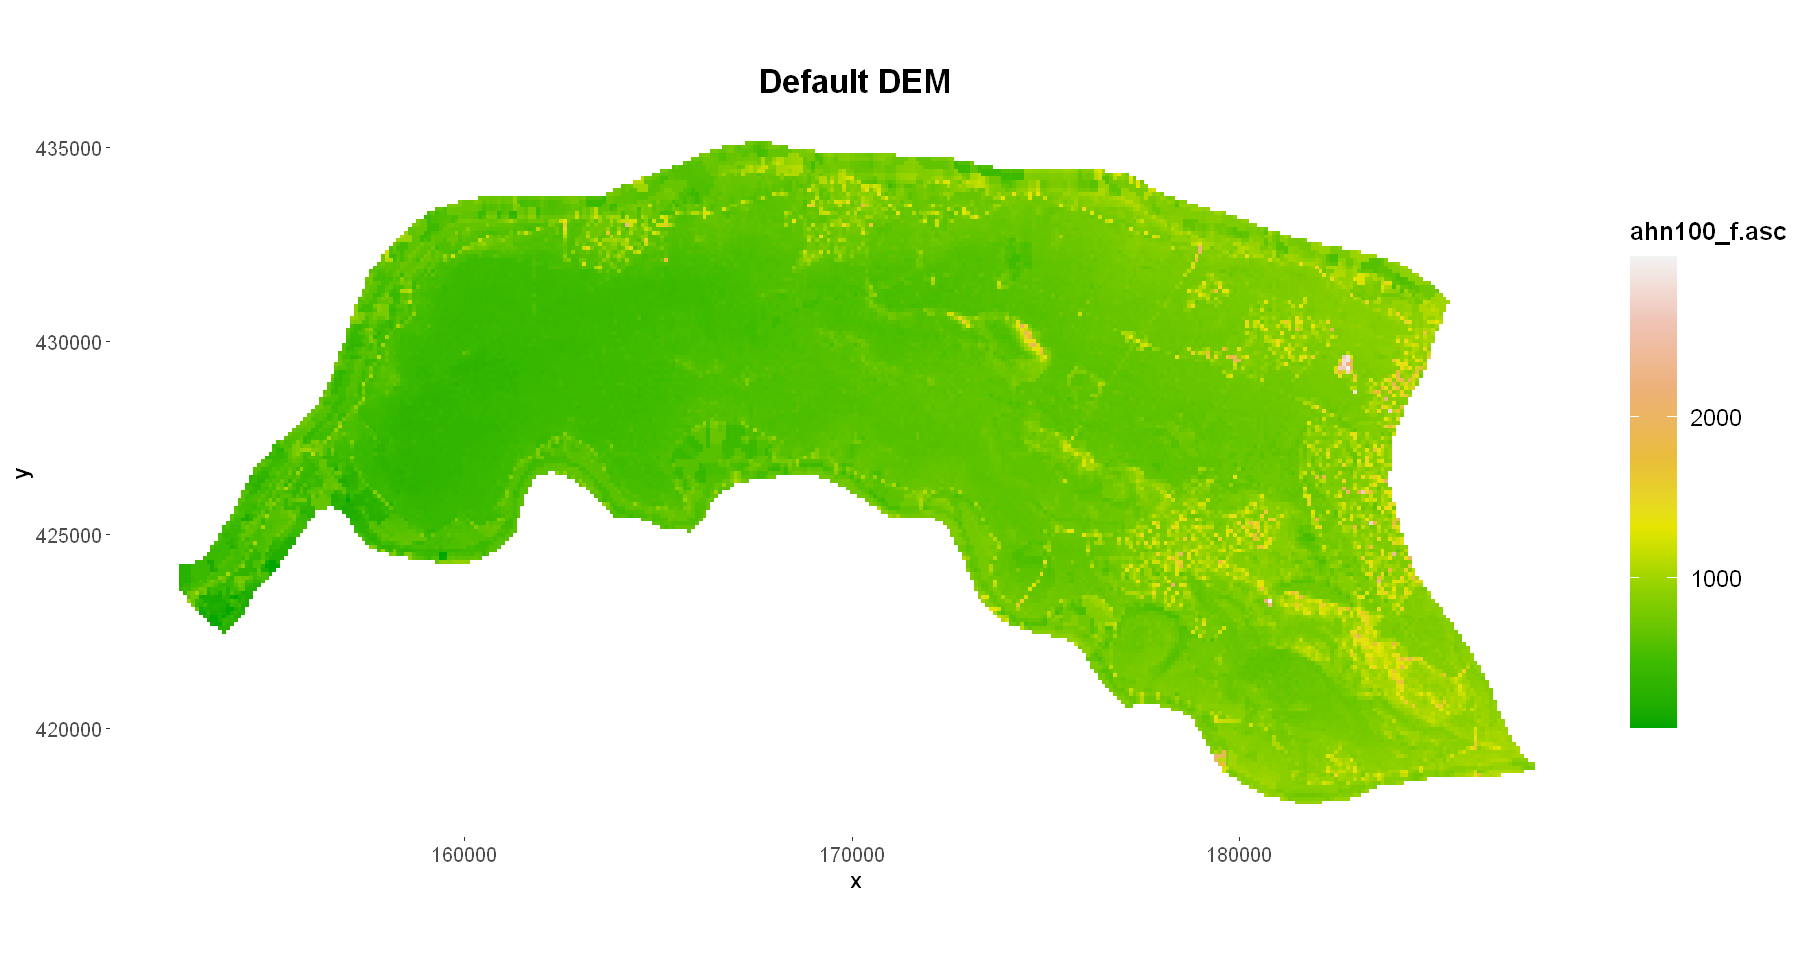

In [5]:
ggplot() + geom_stars(data = ahn) + 
scale_fill_gradientn(colours = terrain.colors(8), na.value="white") + 
coord_fixed() + template + ggtitle("Default DEM") 

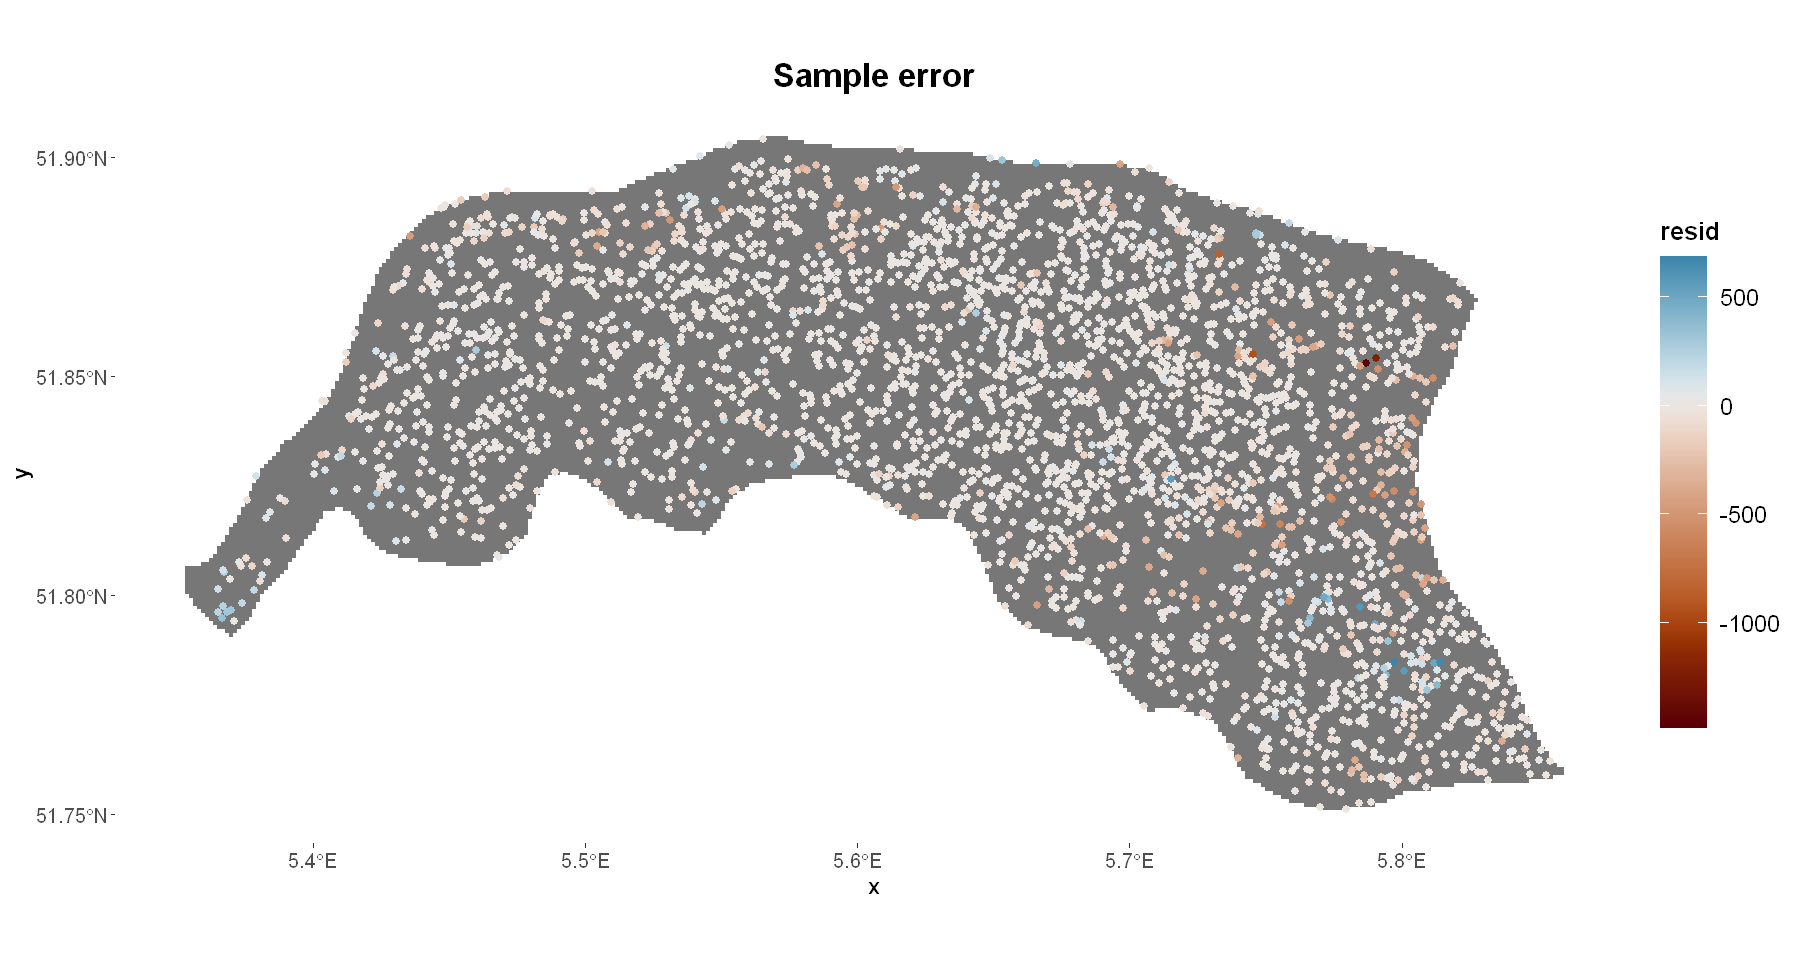

In [209]:
ggplot() + 
  geom_stars(data = mask, show.legend = FALSE) + scale_fill_scico(palette = "grayC", na.value="white") + 
  template + ggtitle("Sample error") + new_scale_fill() + 
  geom_sf(data=sample_error, aes(color=resid), size=2) + 
  scale_color_scico(palette = "vik", midpoint = 0, direction=-1)  

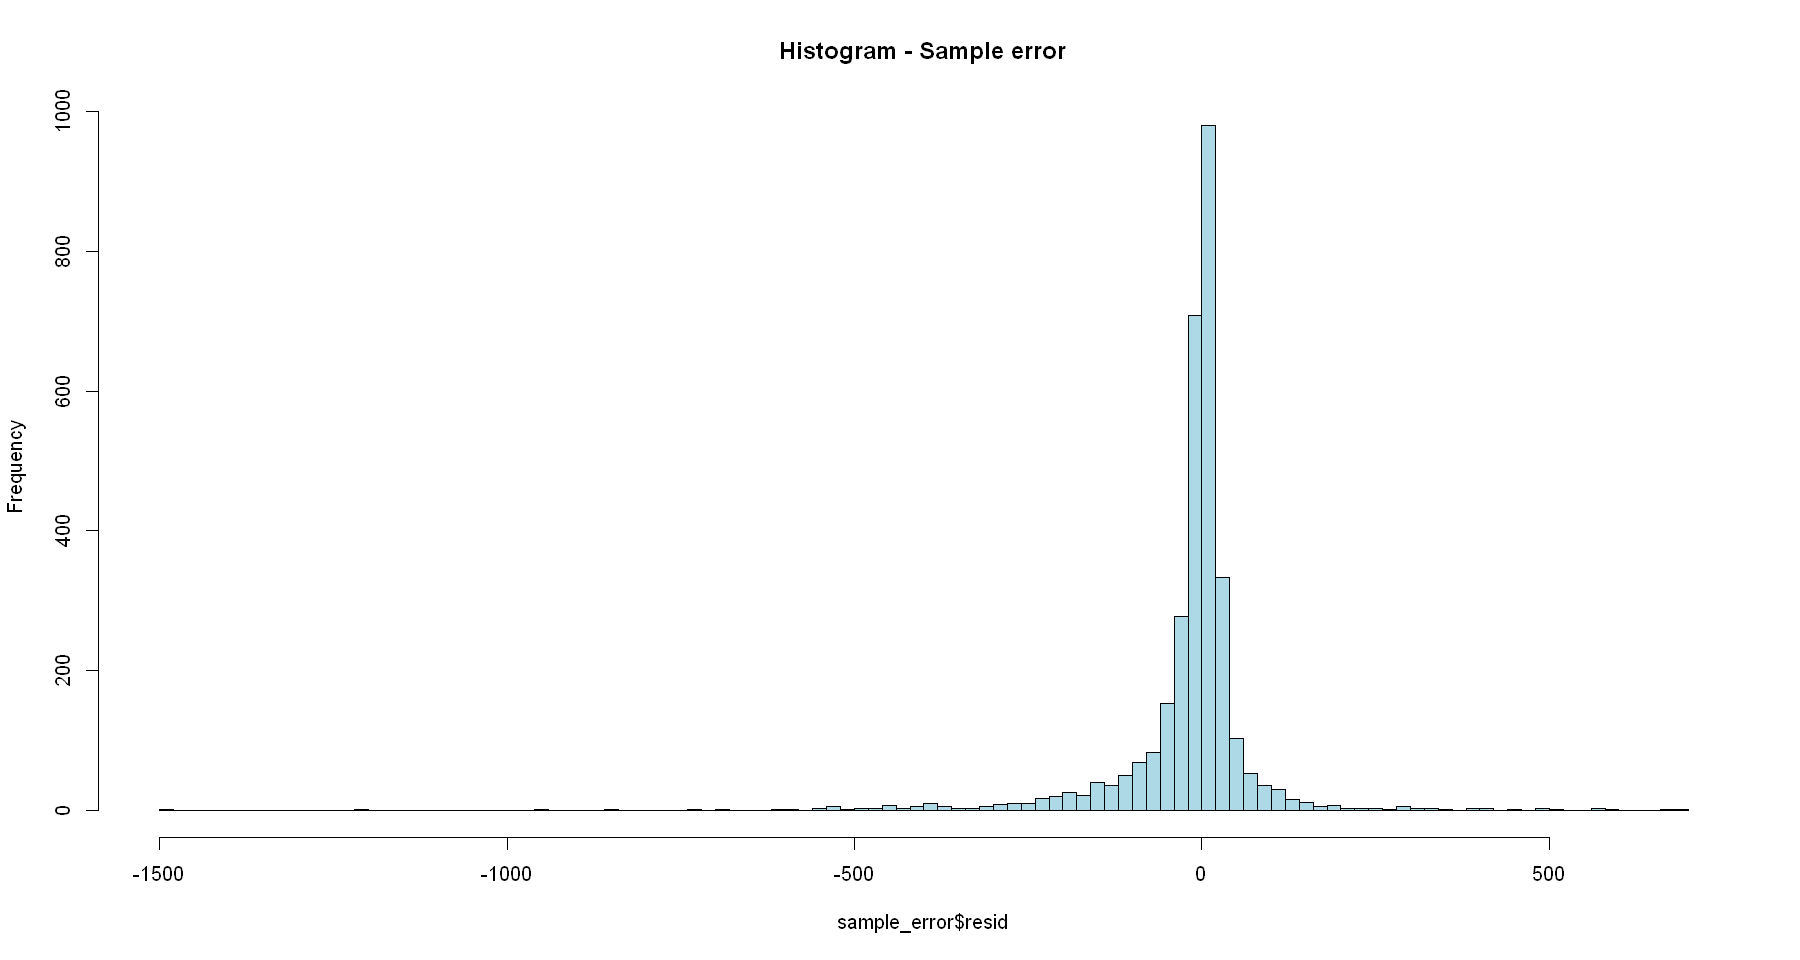

In [215]:
hist(sample_error$resid, breaks=100, col="lightblue", main="Histogram - Sample error")

### Spatial correlation and interpolation

**Semivariogram**

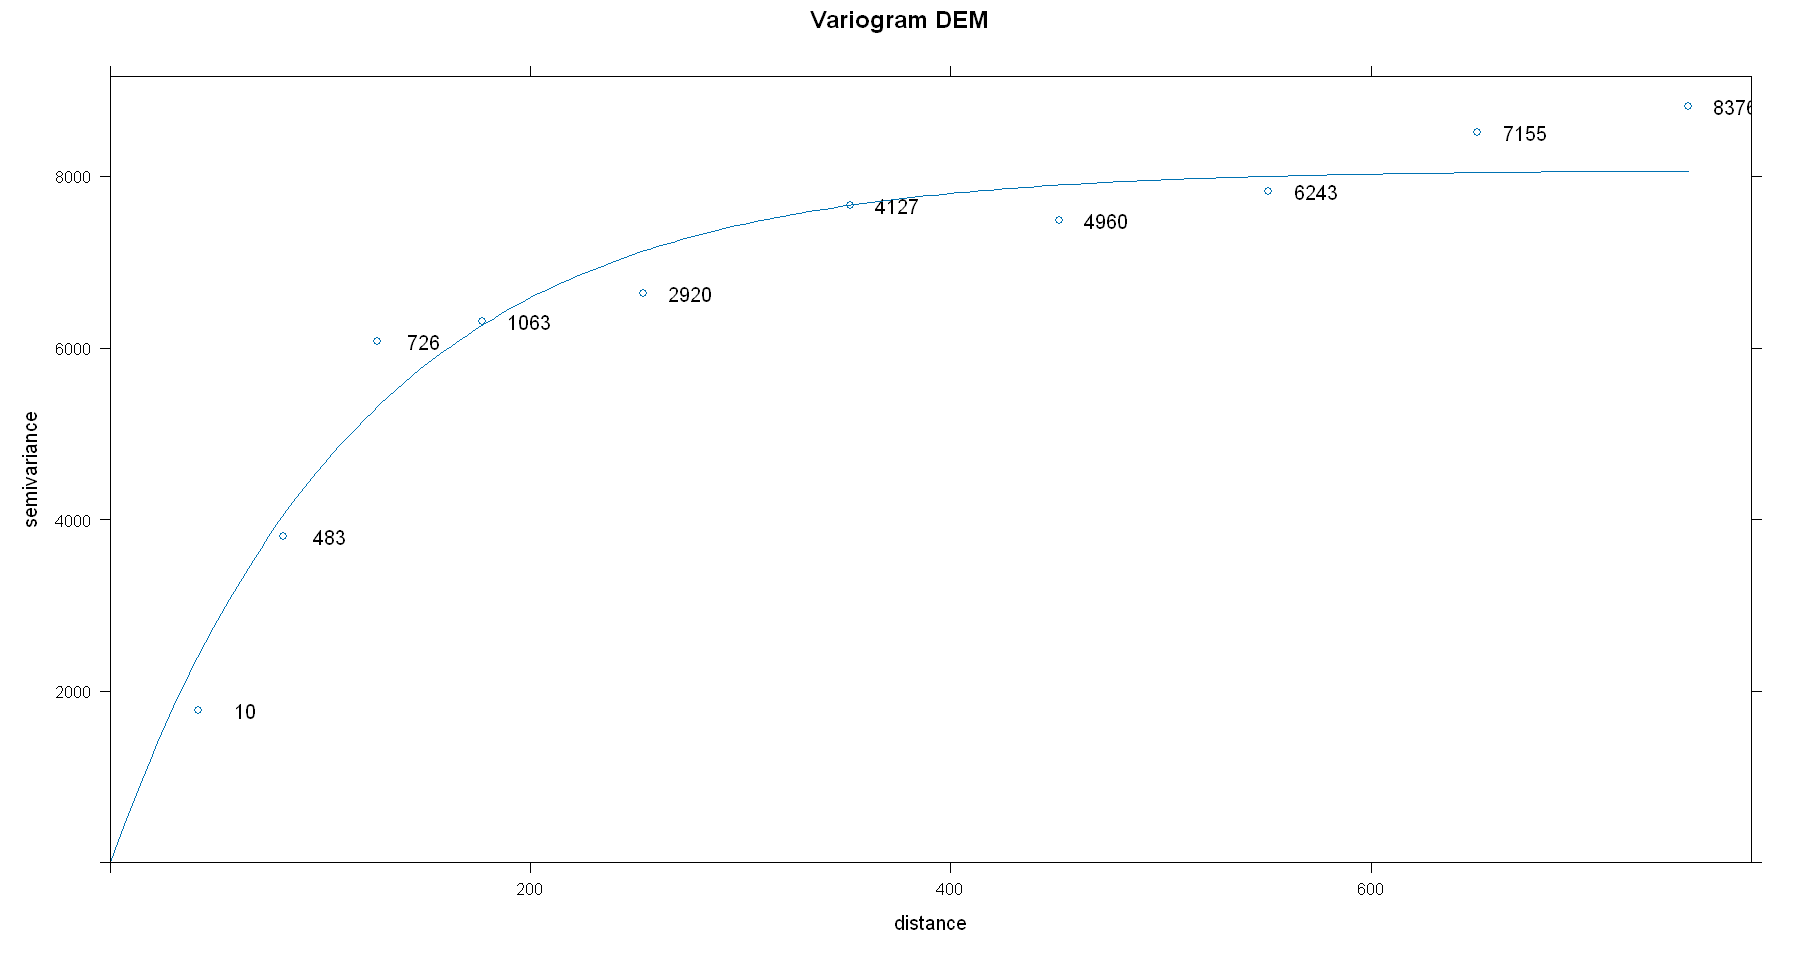

In [216]:
# define gstat object and compute variogram
gdem <- gstat(id = "dem", formula = resid~1, data = sample_error)
vgdem <- variogram(gdem, boundaries=c(1:3*50,2:8*100)) # 50 100 150 200 300 400 500 600 700 800

# variogram model
vgmdem <- vgm(nugget = 0, psill = 6000, range = 200, model = "Exp")

vgmdem <- fit.variogram(vgdem, vgmdem)
plot(vgdem,vgmdem, main="Variogram DEM", plot.numbers = TRUE)

**Ordinary kriging**

In [221]:
# point kriging
resid <- krige(resid~1, sample_error, newdata = mask, model = vgmdem, nmax=25)

resid$ok_pred <- resid$var1.pred
resid$ok_var <- resid$var1.var
resid$ok_sd <- sqrt(resid$var1.var)

[using ordinary kriging]


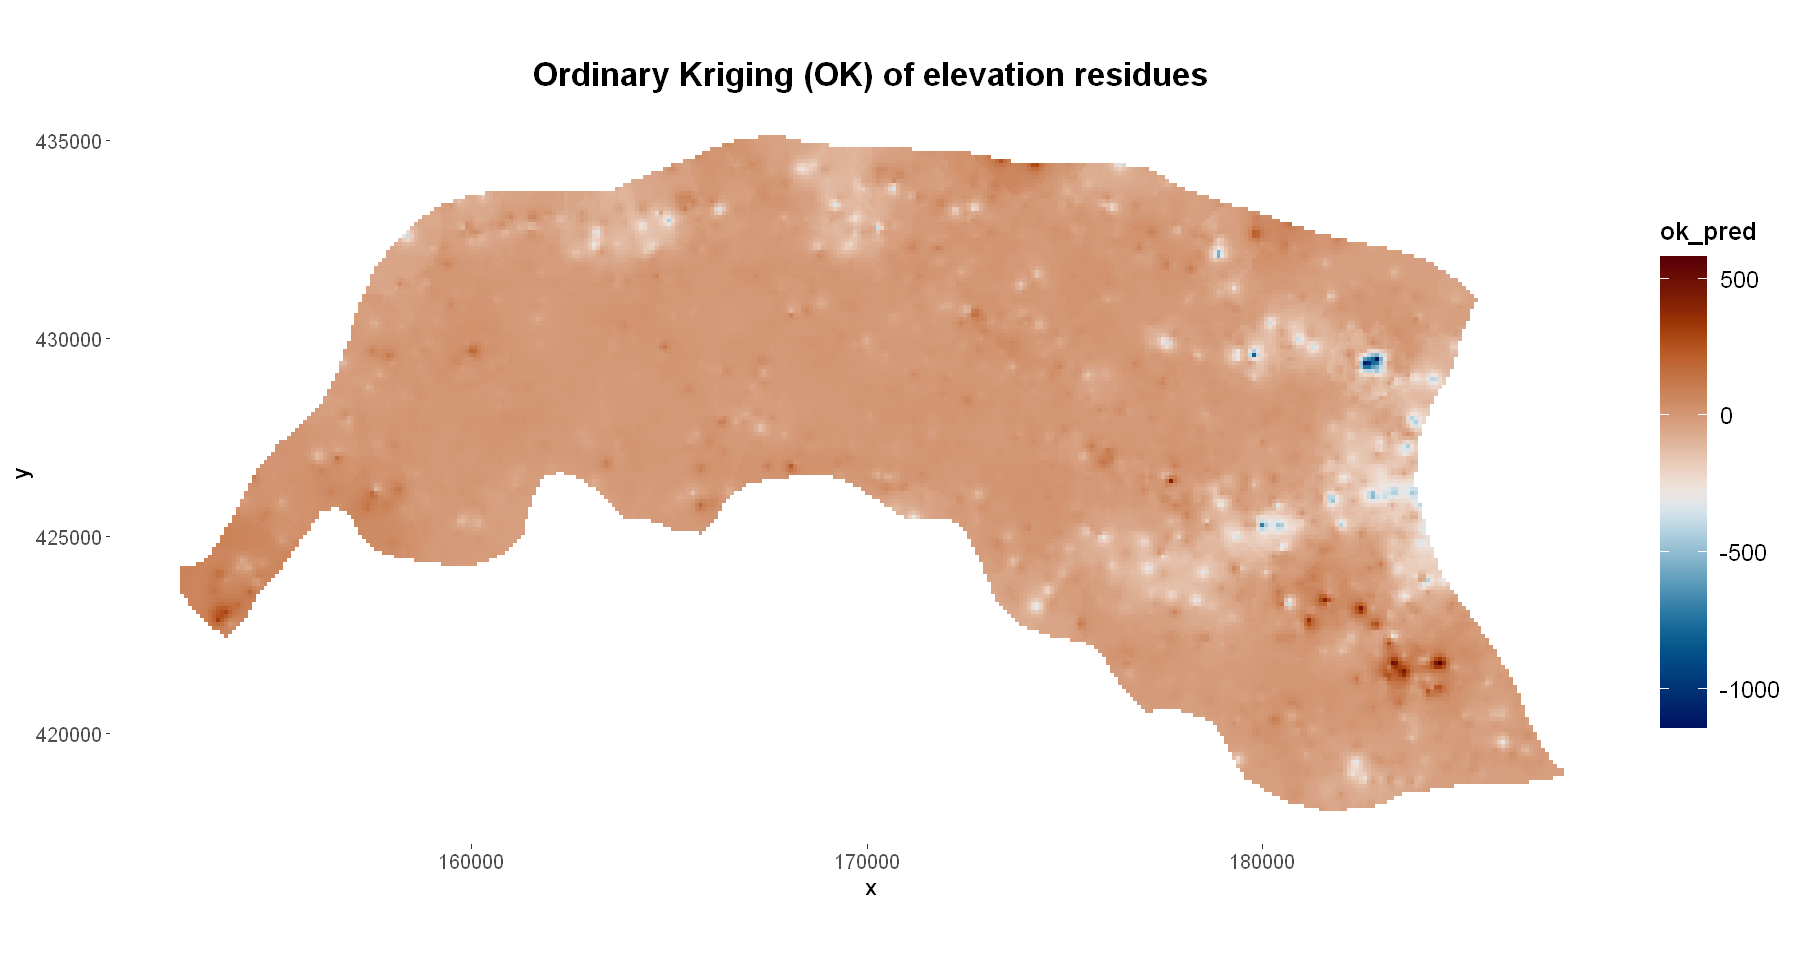

In [222]:
ggplot() + geom_stars(data=resid["ok_pred"]) + 
scale_fill_scico(palette = "vik", na.value="white") +
template + coord_fixed() + ggtitle("Ordinary Kriging (OK) of elevation residues")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


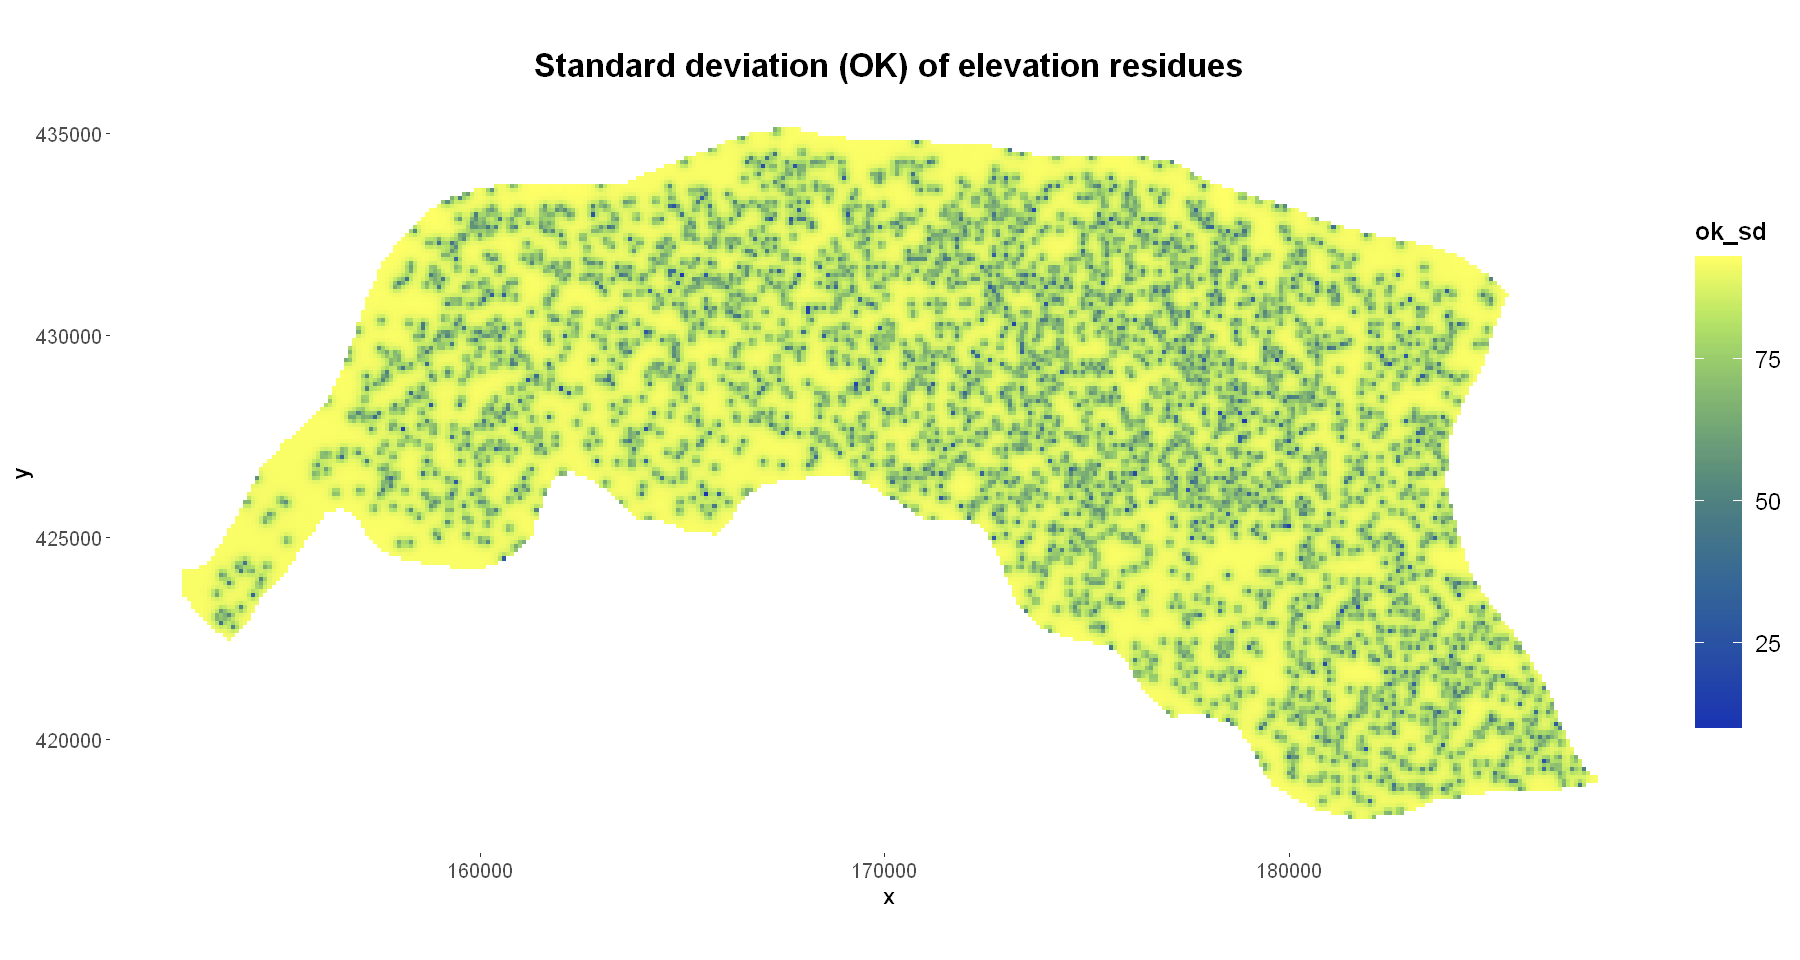

In [223]:
ggplot() + 
geom_stars(data=resid["ok_sd"]) + coord_fixed() + template + coord_fixed() +
scale_fill_scico(palette = "imola", na.value="white") +
ggtitle("Standard deviation (OK) of elevation residues")

**Cross-validation**

In [224]:
# *** Cross-validation Ordinary kriging (OK) ***
resid.xv <- krige.cv(resid~1, sample_error, vgmdem, nmax=25)

In [225]:
str(resid.xv)

Classes 'sf' and 'data.frame':	3193 obs. of  7 variables:
 $ var1.pred: num  -2.27 -151.39 4.97 12.26 3.26 ...
 $ var1.var : num  5334 5993 7318 5840 7642 ...
 $ observed : num  -3.16 -272.01 22.46 25.41 -13.17 ...
 $ residual : num  -0.884 -120.619 17.493 13.15 -16.423 ...
 $ zscore   : num  -0.0121 -1.5581 0.2045 0.1721 -0.1879 ...
 $ fold     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ geometry :sfc_POINT of length 3193; first list element:  'XY' num  166193 430579
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA NA NA NA NA NA
  ..- attr(*, "names")= chr [1:6] "var1.pred" "var1.var" "observed" "residual" ...


In [226]:
mean(resid.xv$zscore); sd(resid.xv$zscore)

[1] -0.005453616

[1] 1.025453

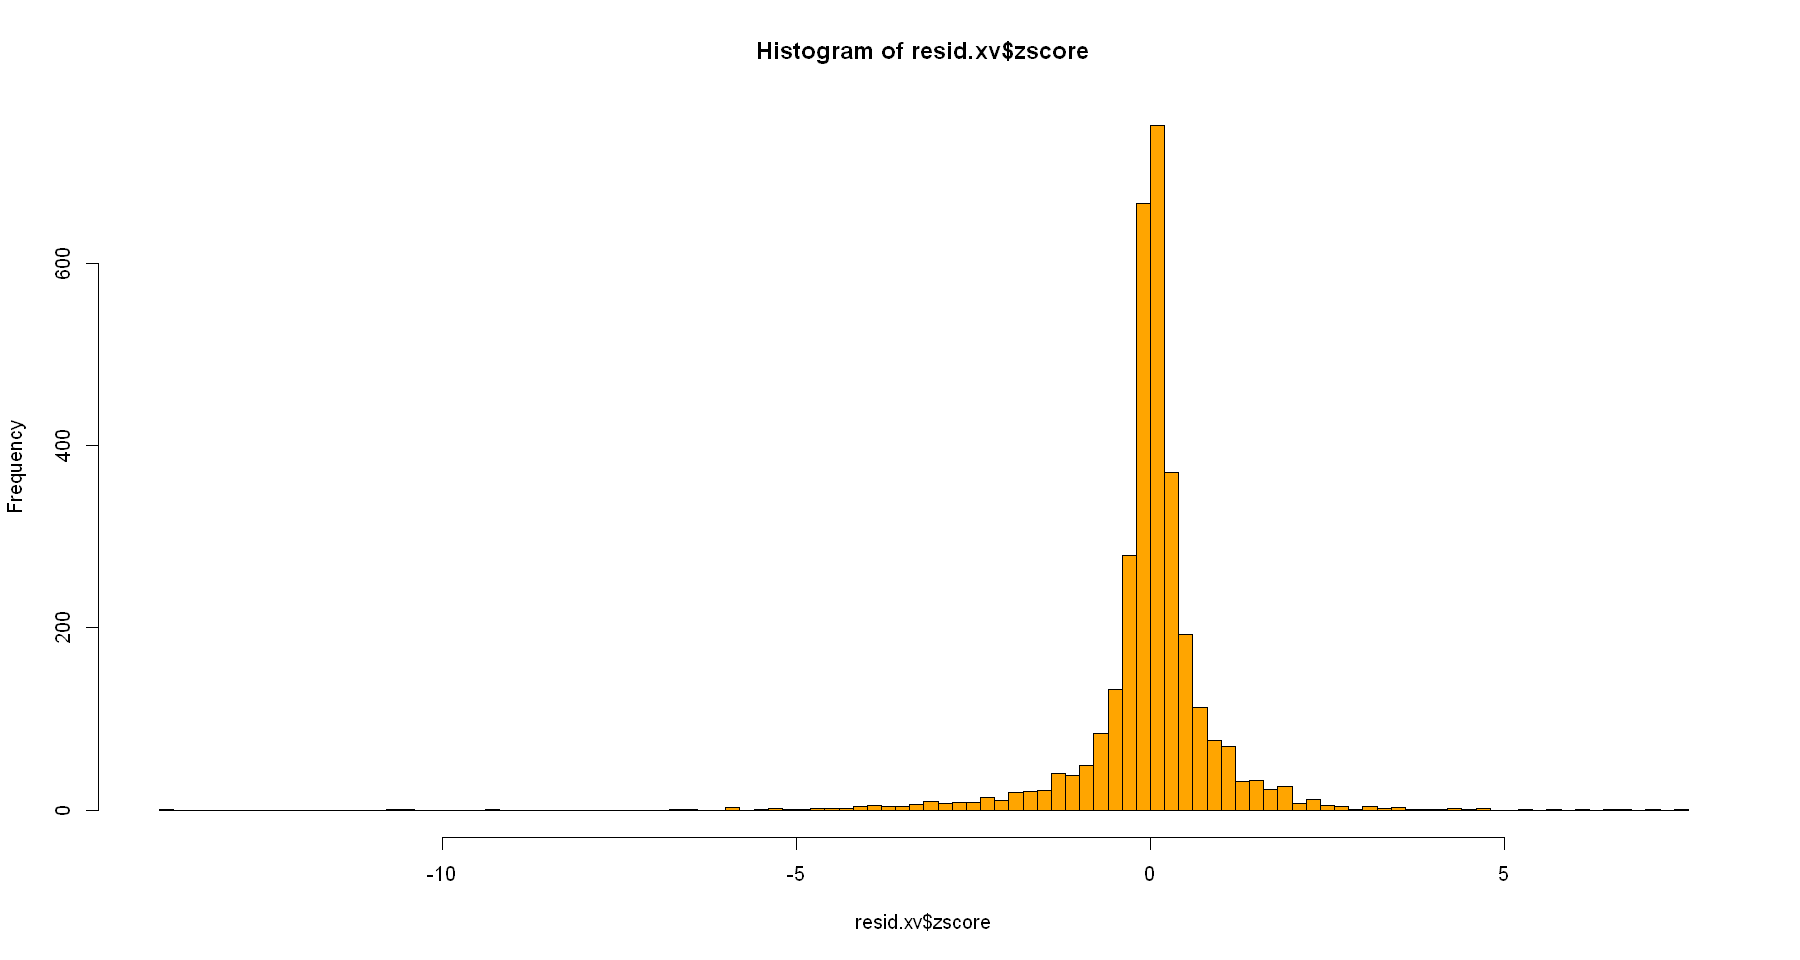

In [231]:
hist(resid.xv$zscore, breaks=100, col="orange")

In [232]:
# Bubble plot of the residuals
resid.xv$sign <- factor(ifelse(resid.xv$residual > 0, 1, 0), 
                        labels = c("neg.", "pos."))

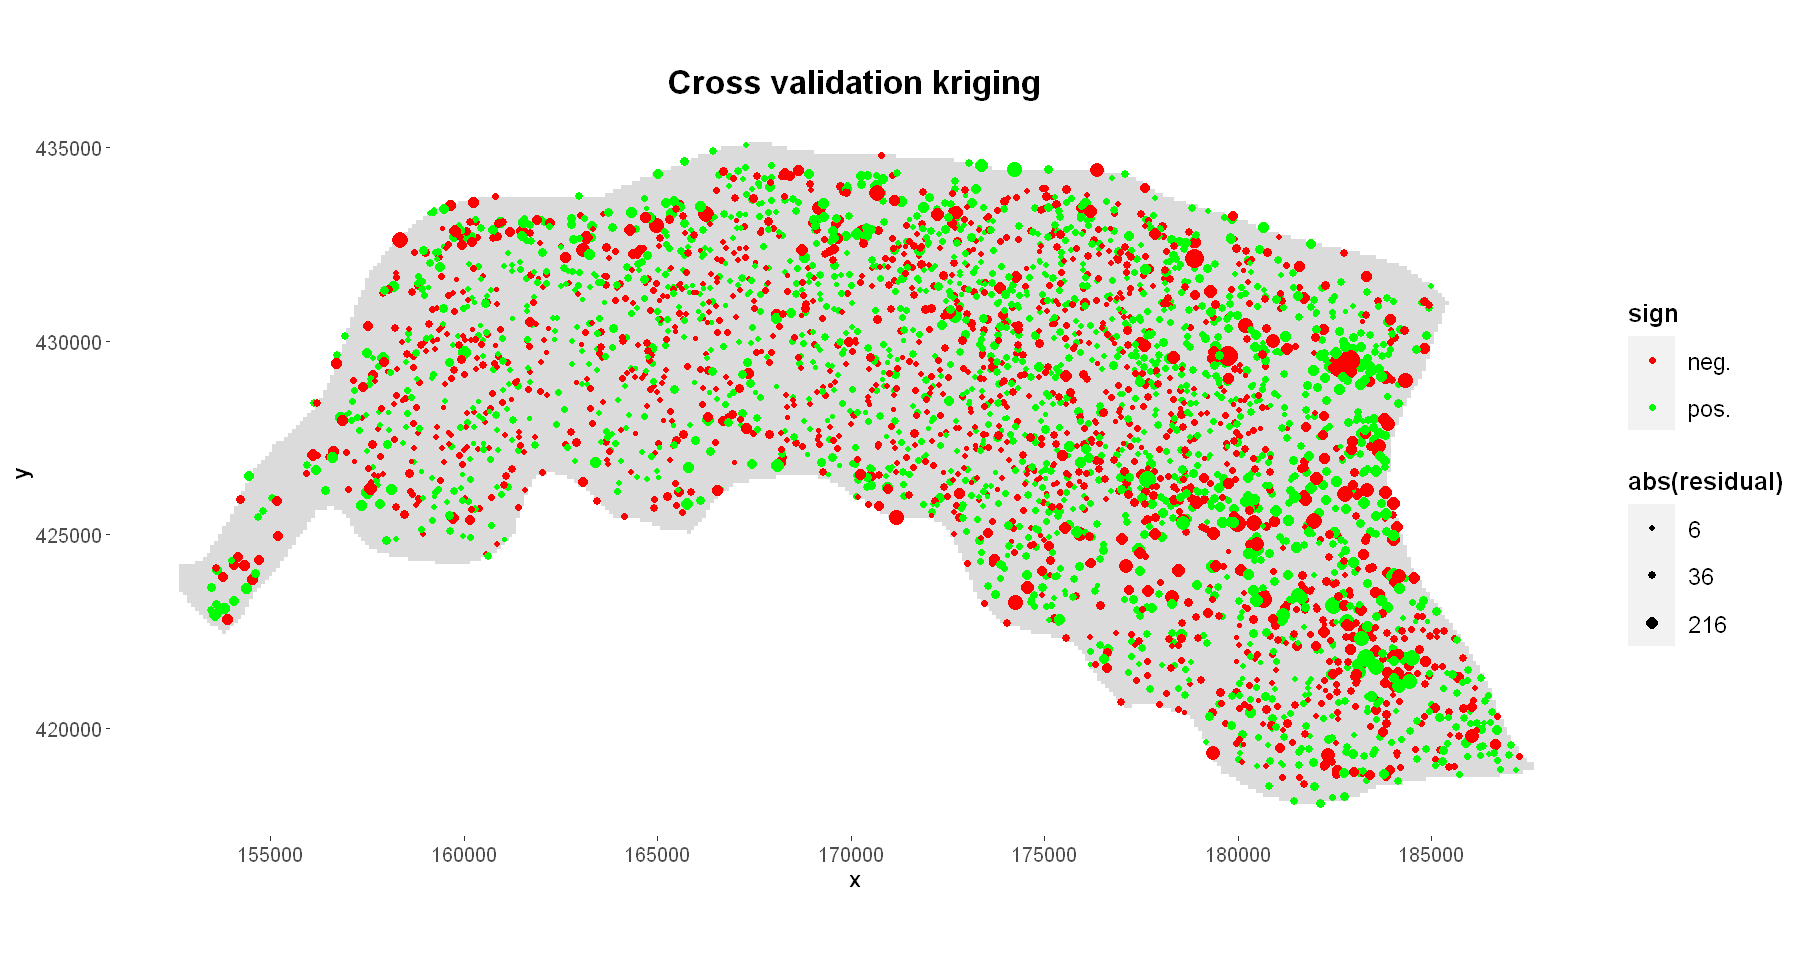

In [277]:
ggplot() + geom_stars(data=mask["mask100.asc"], show.legend = FALSE) + 
  #scale_fill_scico(palette = "vik", na.value="white") +
  scale_fill_gradientn(colors="grey86", na.value="white") +
  geom_sf(data=resid.xv, aes(color=sign, size=abs(residual)), shape = 16) +
  new_scale_fill() +
  scale_size(breaks = 6^(1:3)) + template + 
  scale_color_manual(values=c("red", "green")) +
  ggtitle("Cross validation kriging") +
  theme(legend.key.height = unit(1, 'cm'), #change legend key height
       legend.text = element_text(size=14)) #change legend key width

## Monte Carlo simulation

**Uncertainty of DEM**

In [279]:
# number of Monte Carlo runs
MC <- 100

# simulate lead concentration maps
set.seed(100)
resid.sim <- krige(resid~1, sample_error, newdata = mask, vgmdem, nsim = MC, nmax = 25)

drawing 100 GLS realisations of beta...
[using conditional Gaussian simulation]


In [132]:
if (!dir.exists("./simdem")) dir.create("./simdem")
simheight <- resid.sim + ahn
for(i in 1:100) {
  outname <- file.path("simdem", paste0("realisation", i, ".asc"))
  outdem <- st_redimension(simheight[,,,i], st_dimensions(mask))
  writeRaster(as(outdem, "Raster"), outname, overwrite=TRUE)
}

**Uncertainty of influx**

In [280]:
#seq function means (0[start of number], 25[end number], 0.01[numbers of increment])

set.seed(123456789)
influxes<- round(rnorm(100, mean = 2700, sd = 240))

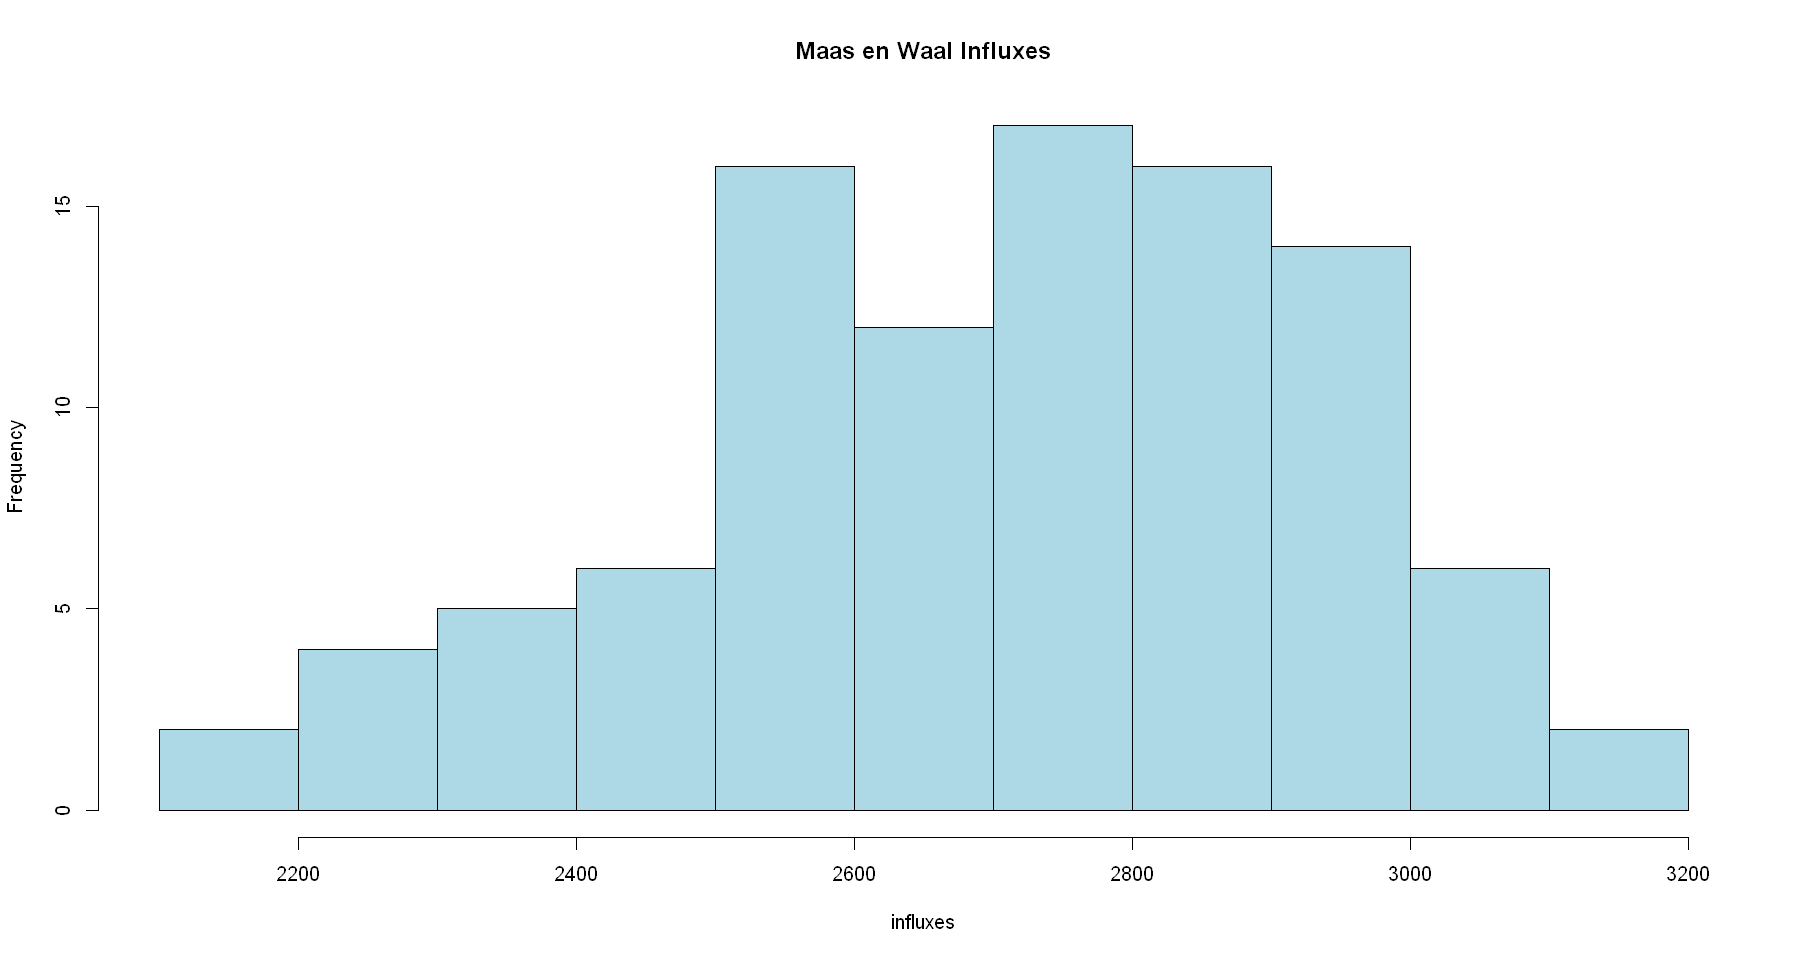

In [281]:
hist(influxes, main = "Maas en Waal Influxes", col = c("light blue"))

In [285]:
#write.table(influxes, "influxes.txt", sep = " ", col.names = FALSE, row.names = FALSE)

print(paste("mean: ", mean(influxes)))
print(paste("sd: ", round(sd(influxes), 2)))

[1] "mean:  2706.02"
[1] "sd:  230.85"


### Modelling in NetLogo

### Loading the experiments

In [136]:
path_cu <- "results/certain-uncertain_72hours_corrected/"
path_uc <- "results/uncertain-certain_72hours_corrected/"
path_uu <- "results/uncertain-uncertain_72hours_corrected/"

# Read all flooding model results into a 3D array "ar3D"
flist_cu <- list.files(path_cu) # all file names in <mydir>
flist_cu <- flist_cu[grep("_corrected", flist_cu)] # retain only corrected
ar3D_cu = array(dim = c(dim(mask), 100))

flist_uc <- list.files(path_uc) # all file names in <mydir>
flist_uc <- flist_uc[grep("_corrected", flist_uc)] # retain only corrected
ar3D_uc = array(dim = c(dim(mask), 100))

flist_uu <- list.files(path_uu) # all file names in <mydir>
flist_uu <- flist_uu[grep("_corrected", flist_uu)] # retain only corrected
ar3D_uu = array(dim = c(dim(mask), 100))

In [241]:
i <- 1
for(in_name in flist_cu)
{
 in_name <- paste0(path_cu, in_name)
 ar3D_cu[,,i] <- read_stars(in_name)[[1]]
 i <- i + 1
}

i <- 1
for(in_name in flist_uc)
{
  in_name <- paste0(path_uc, in_name)
  ar3D_uc[,,i] <- read_stars(in_name)[[1]]
  i <- i + 1
}

i <- 1
for(in_name in flist_uu)
{
  in_name <- paste0(path_uu, in_name)
  ar3D_uu[,,i] <- read_stars(in_name)[[1]]
  i <- i + 1
}

In [245]:
ar3D_cu[is.na(ar3D_cu)] <- 0 # set NA to 0
ar3D_uc[is.na(ar3D_uc)] <- 0 # set NA to 0
ar3D_uu[is.na(ar3D_uu)] <- 0 # set NA to 0

**Safe/Unsafe map 95% chances**

In [246]:
# Uncertain (dem) - uncertain (flux)

## Compute probability of flooding
prob_uu <- apply(ar3D_uu, c(1,2), function(x) mean(ifelse(x > 0, 1, 0)))

In [247]:
## Convert to stars raster
st_prob_uu <- st_as_stars(prob_uu)
names(st_prob_uu) <- "prob"
attr(st_prob_uu, "dimensions") <- attr(mask, "dimensions")

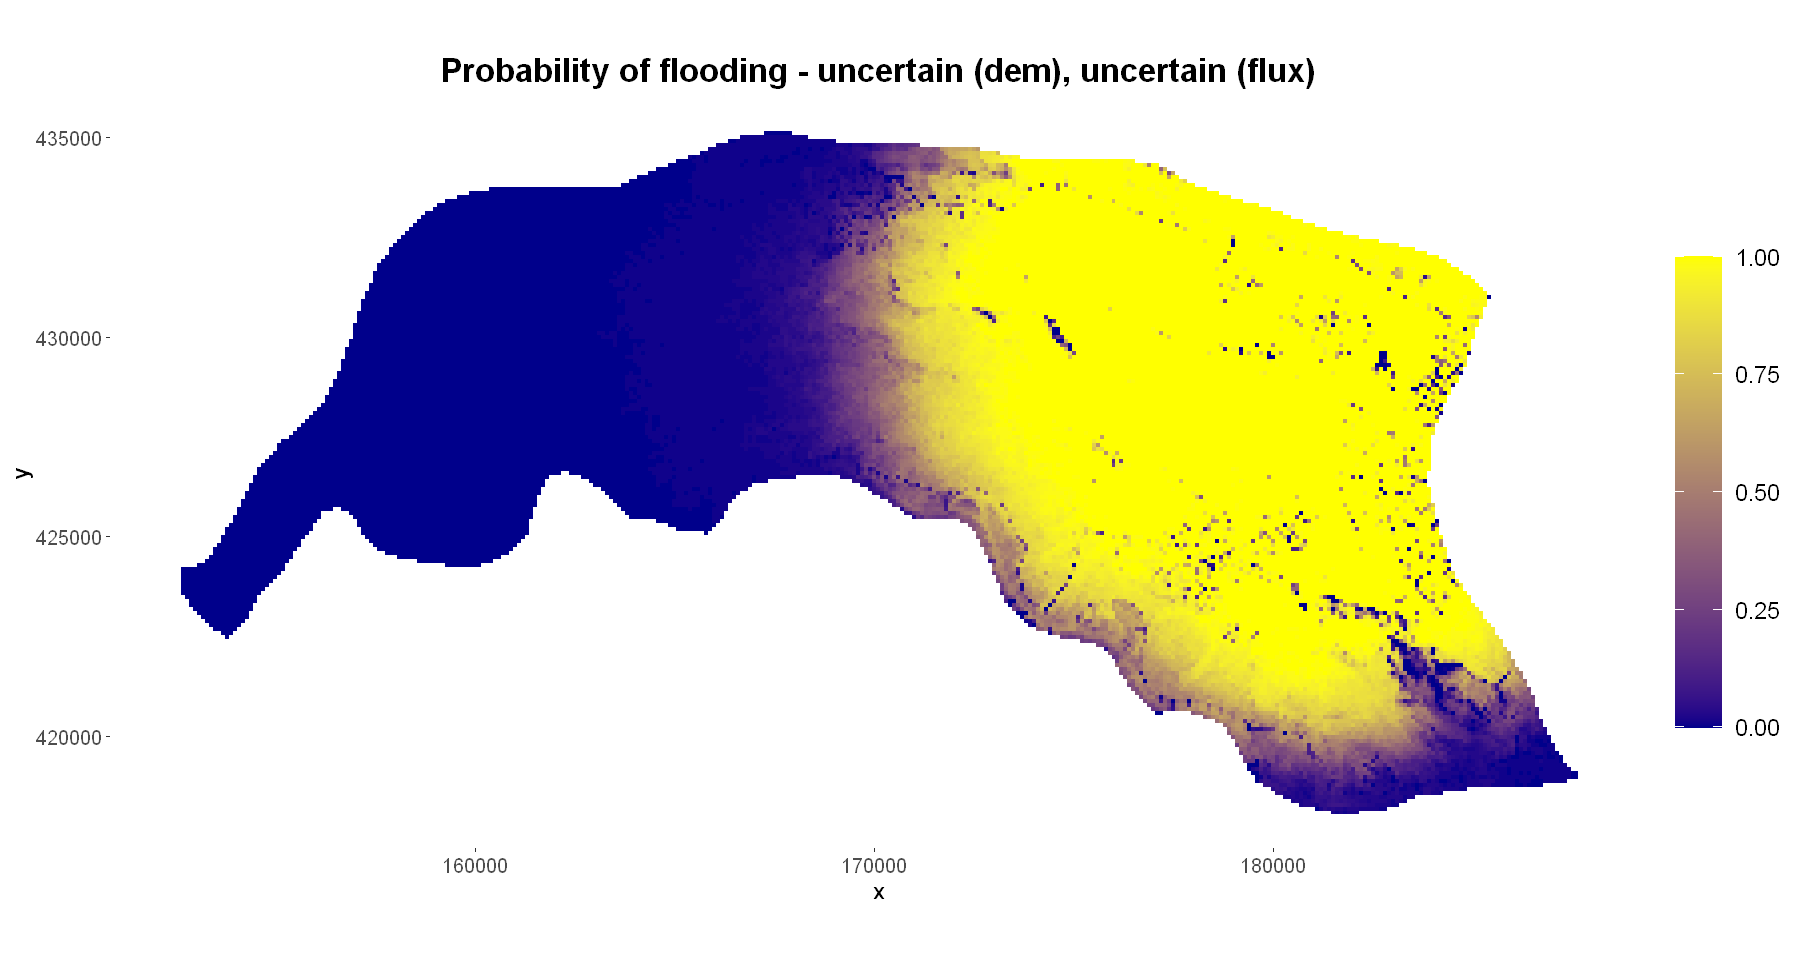

In [248]:
## plot
ggplot() + geom_stars(data=st_prob_uu + mask) + coord_fixed() +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") + template +
  ggtitle("Probability of flooding - uncertain (dem), uncertain (flux)")

In [249]:
st_prob_uu["prob"] <- st_prob_uu["prob"] + mask
st_prob_uu$p95 <- factor(ifelse(st_prob_uu$prob > 0.05, 1, 0), levels=c(0,1), labels=c("safe", "unsafe"))

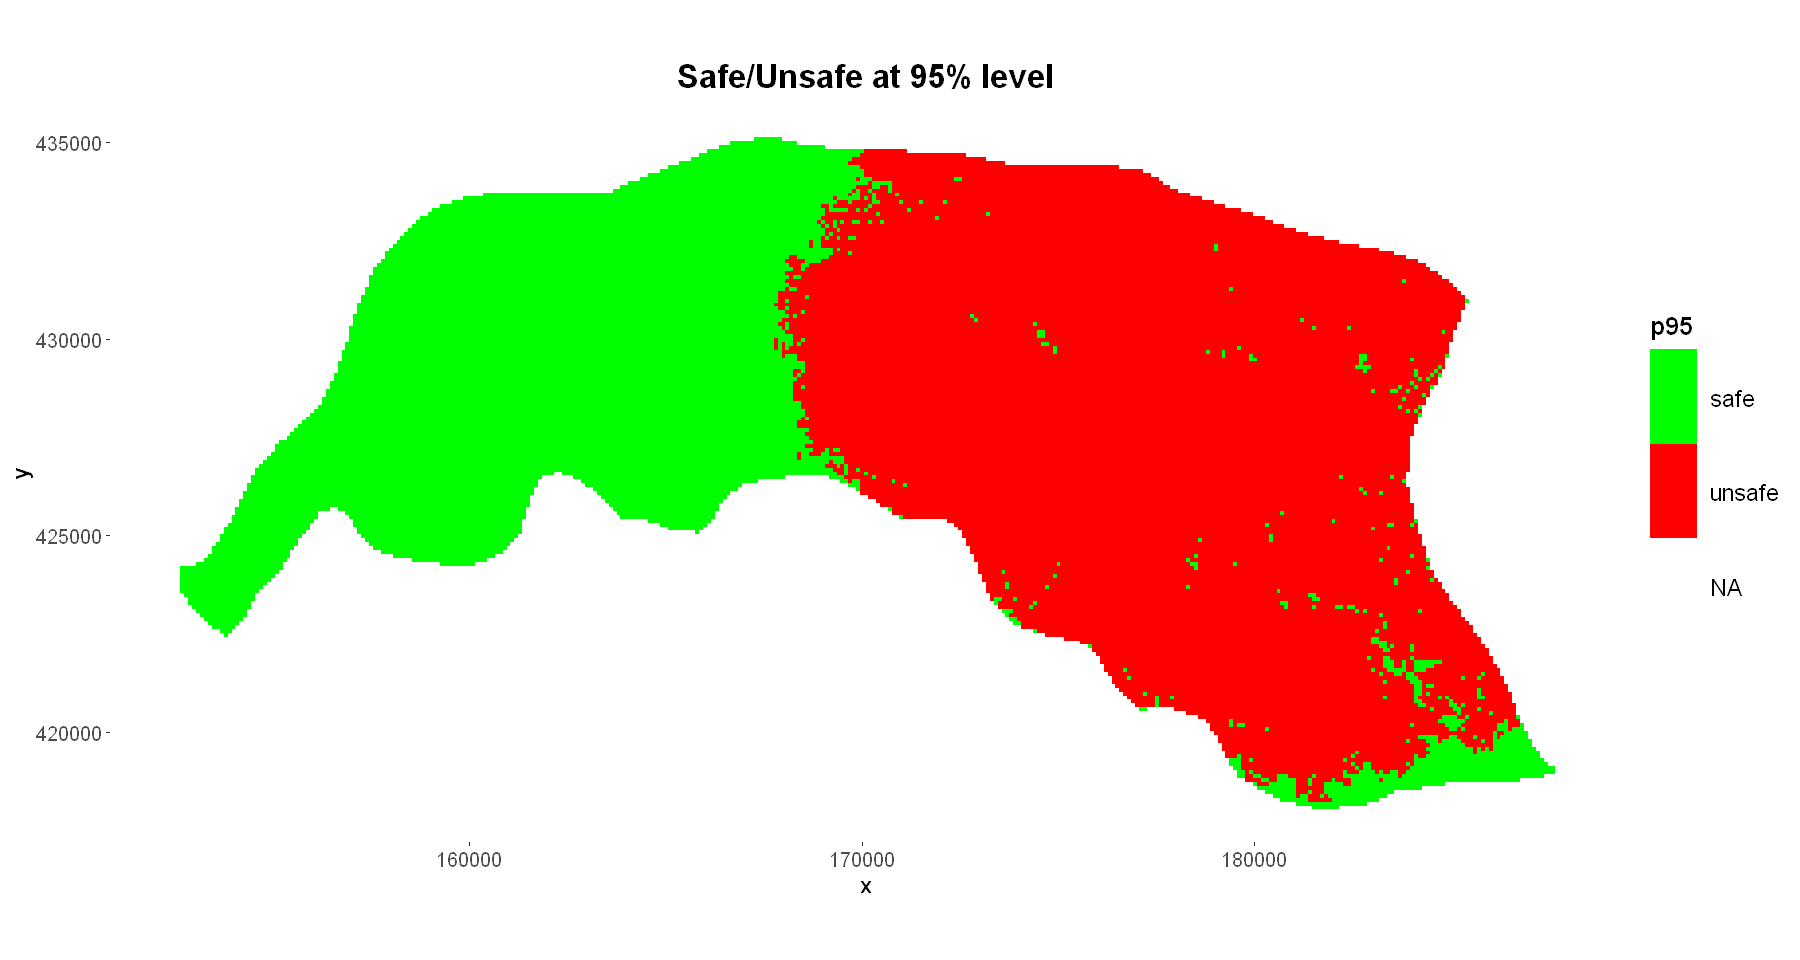

In [250]:
ggplot() + template +
  geom_stars(data = st_prob_uu["p95"]) + coord_fixed() + 
  scale_fill_manual(values=c("green", "red"), na.value="white") +
  ggtitle("Safe/Unsafe at 95% level") 

#write_stars(st_prob_uu["p95"], 'prob_uu_95.tif')

**water depth - mean**

In [254]:
# Certain (dem) - uncertain (flux)

## Compute probability of flooding
mean_cu <- apply(ar3D_cu, c(1,2), function(x) mean(x))
mean_cu <- mean_cu + mask[[1]] # get rid of NA area

In [255]:
## Convert to stars raster
st_mean_cu <- st_as_stars(mean_cu)
names(st_mean_cu) <- "mean"
attr(st_mean_cu, "dimensions") <- attr(mask, "dimensions")

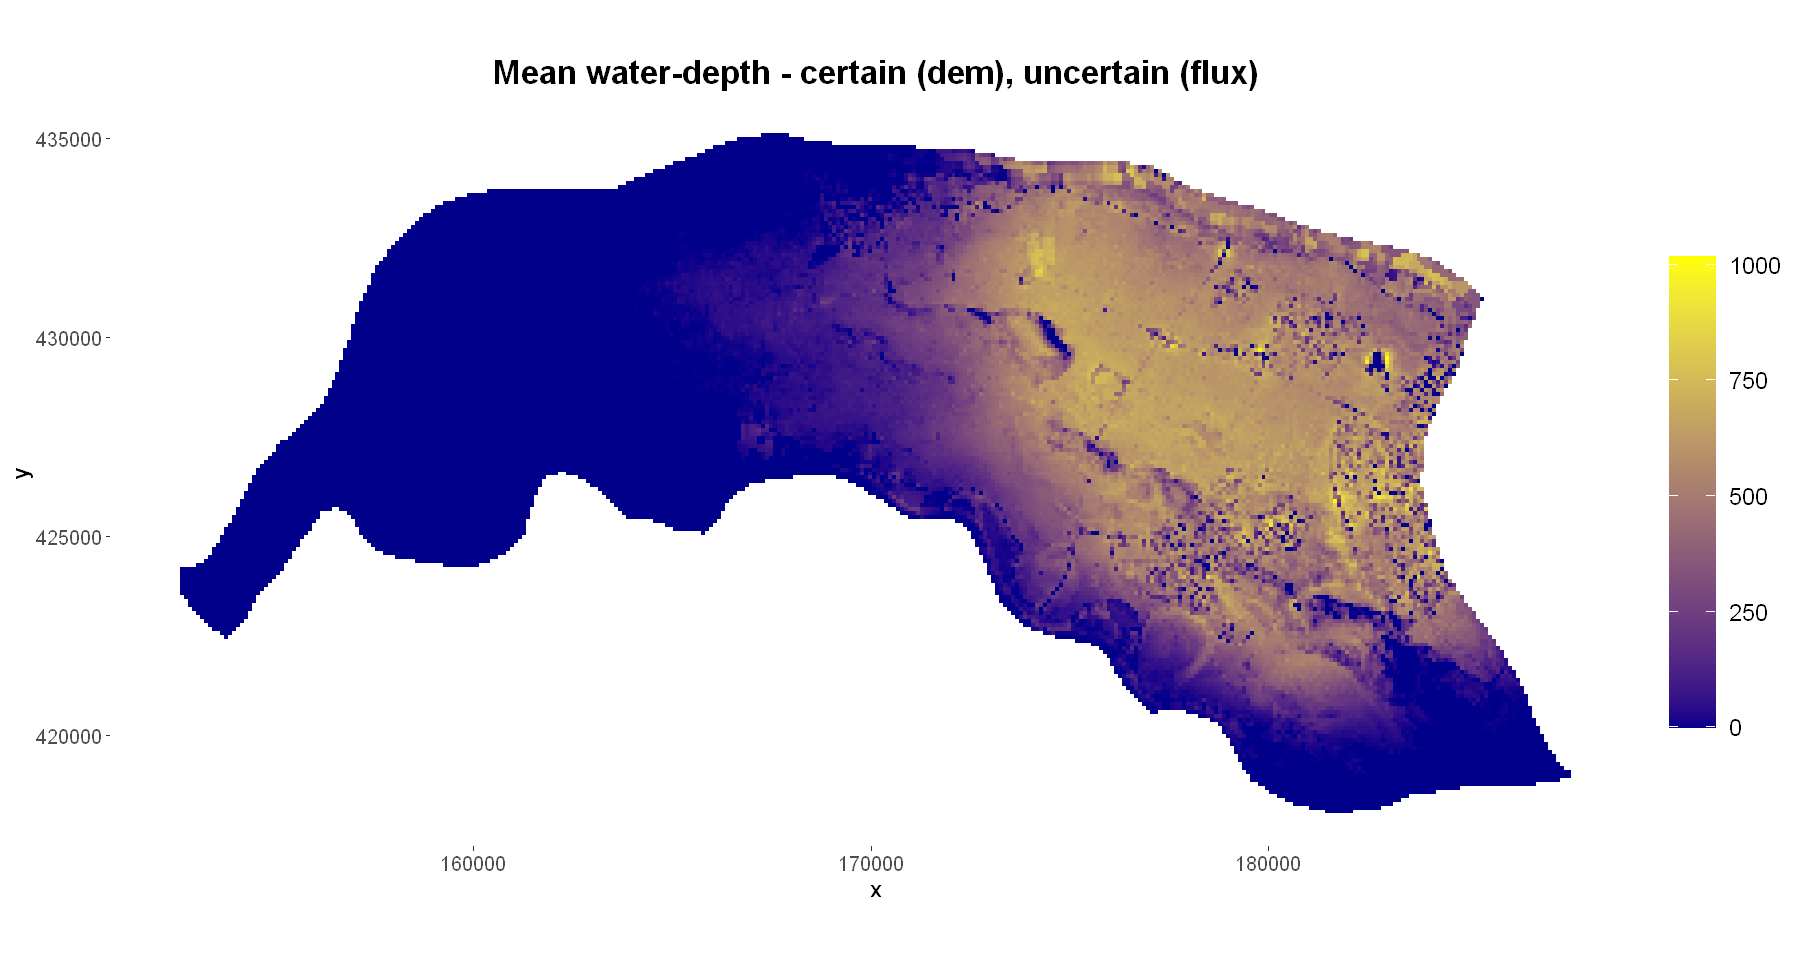

In [257]:
## plot
ggplot() + geom_stars(data=st_mean_cu) + coord_fixed() + template +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Mean water-depth - certain (dem), uncertain (flux)")

In [258]:
# Uncertain (dem) - Certain (flux)

## Compute probability of flooding
mean_uc <- apply(ar3D_uc, c(1,2), function(x) mean(x))
mean_uc <- mean_uc + mask[[1]] # get rid of NA area

In [259]:
## Convert to stars raster
st_mean_uc <- st_as_stars(mean_uc)
names(st_mean_uc) <- "mean"
attr(st_mean_uc, "dimensions") <- attr(mask, "dimensions")

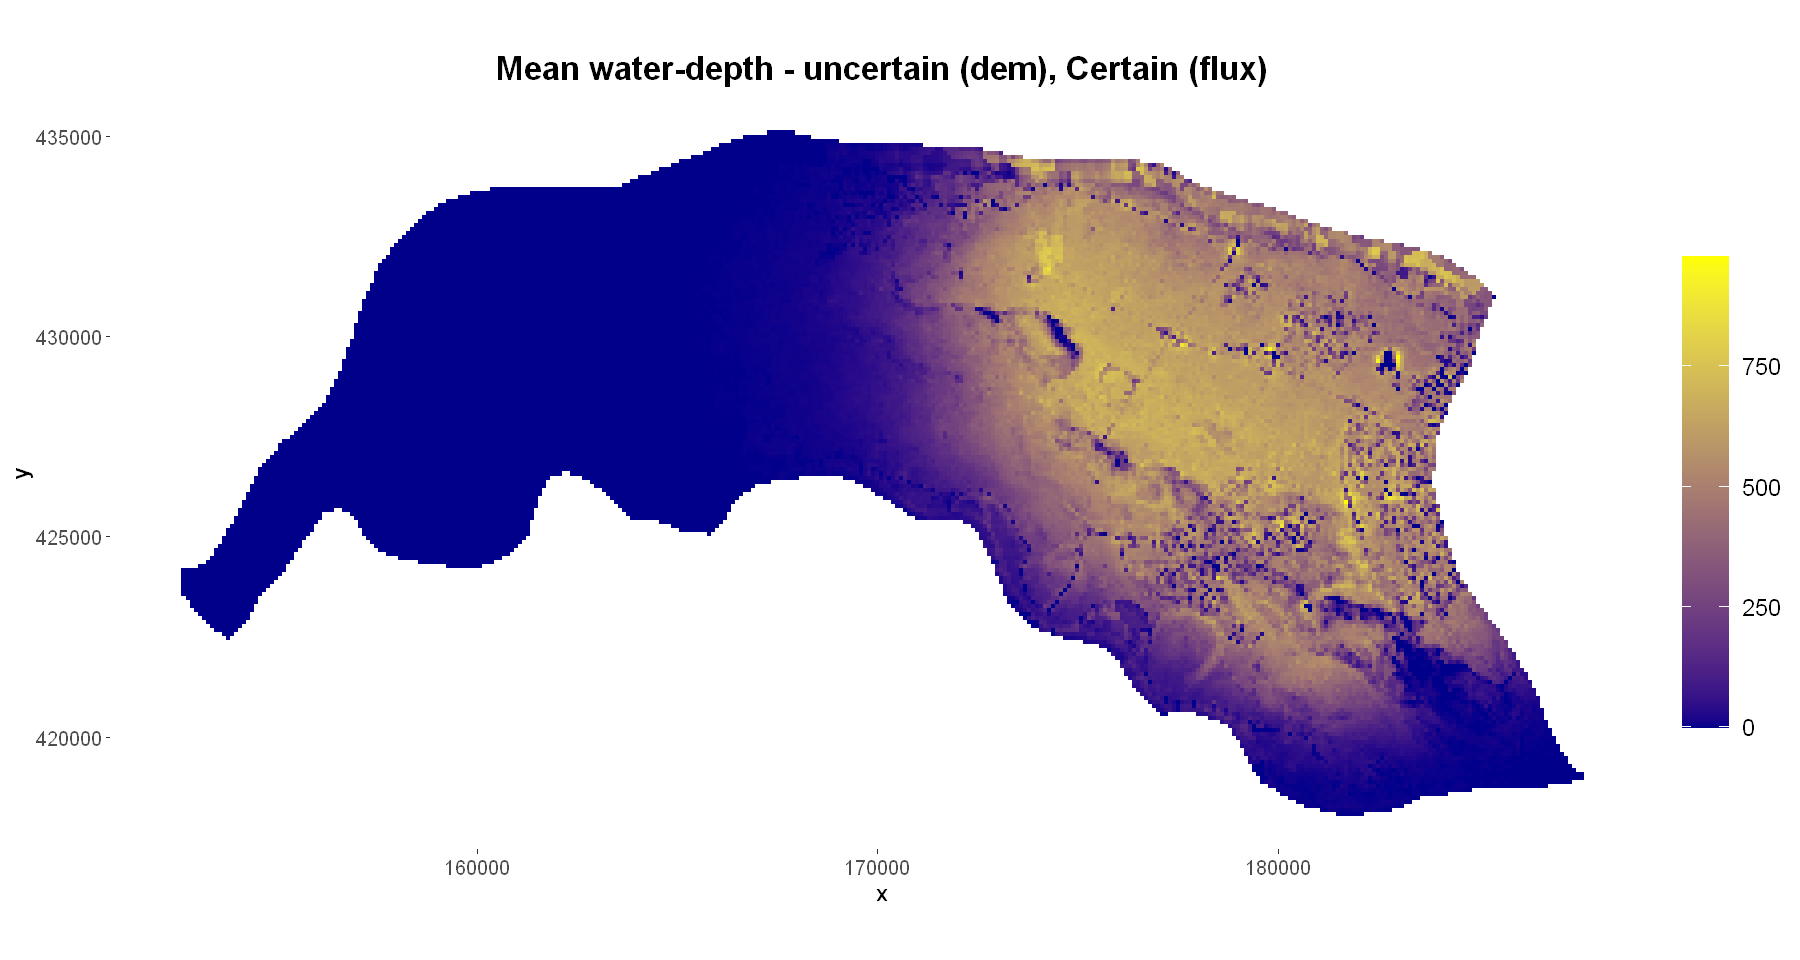

In [260]:
## plot
ggplot() + geom_stars(data=st_mean_uc) + coord_fixed() + template +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Mean water-depth - uncertain (dem), Certain (flux)")

In [261]:
# Uncertain (dem) - uncertain (flux)

## Compute probability of flooding
mean_uu <- apply(ar3D_uu, c(1,2), function(x) mean(x))
mean_uu <- mean_uu + mask[[1]] # get rid of NA area

In [262]:
## Convert to stars raster
st_mean_uu <- st_as_stars(mean_uu)
names(st_mean_uu) <- "mean"
attr(st_mean_uu, "dimensions") <- attr(mask, "dimensions")

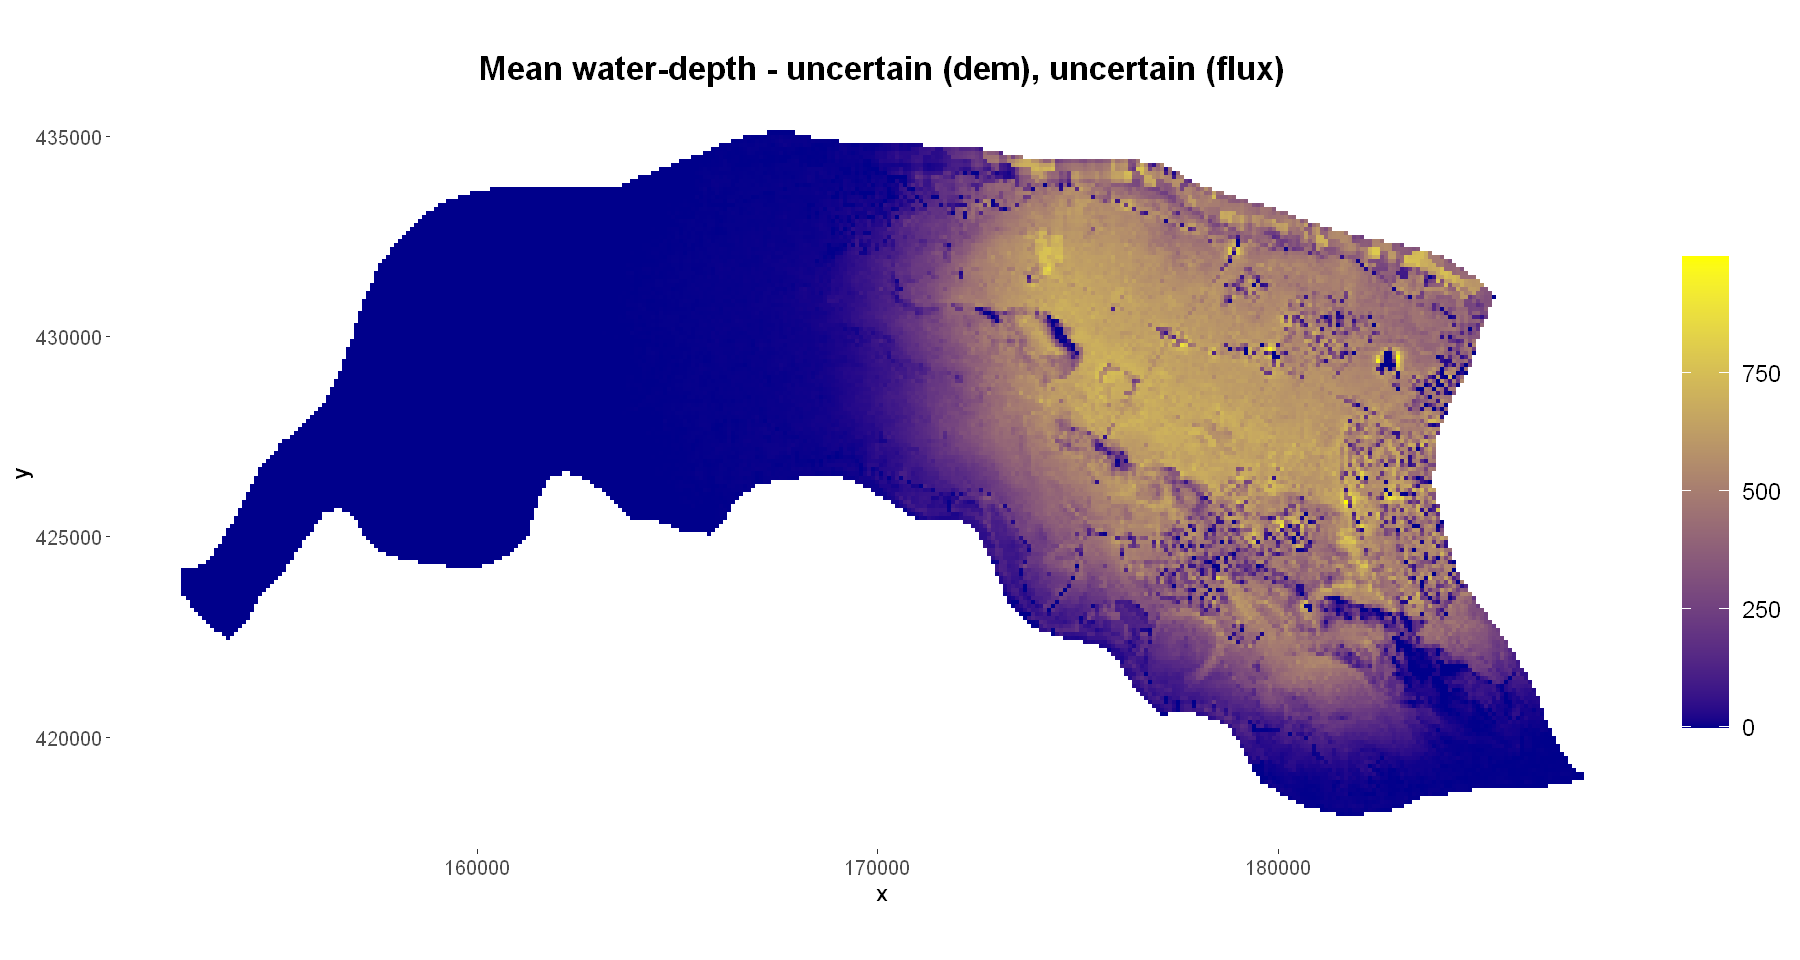

In [263]:
## plot
ggplot() + geom_stars(data=st_mean_uu) + coord_fixed() + template +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Mean water-depth - uncertain (dem), uncertain (flux)")

**water depth - std**

In [264]:
# Certain (dem) - uncertain (flux)

## Compute probability of flooding
sd_cu <- apply(ar3D_cu, c(1,2), function(x) sd(x))
sd_cu <- sd_cu + mask[[1]] # get rid of NA area

In [265]:
## Convert to stars raster
st_sd_cu <- st_as_stars(sd_cu)
names(st_sd_cu) <- "sd"
attr(st_sd_cu, "dimensions") <- attr(mask, "dimensions")

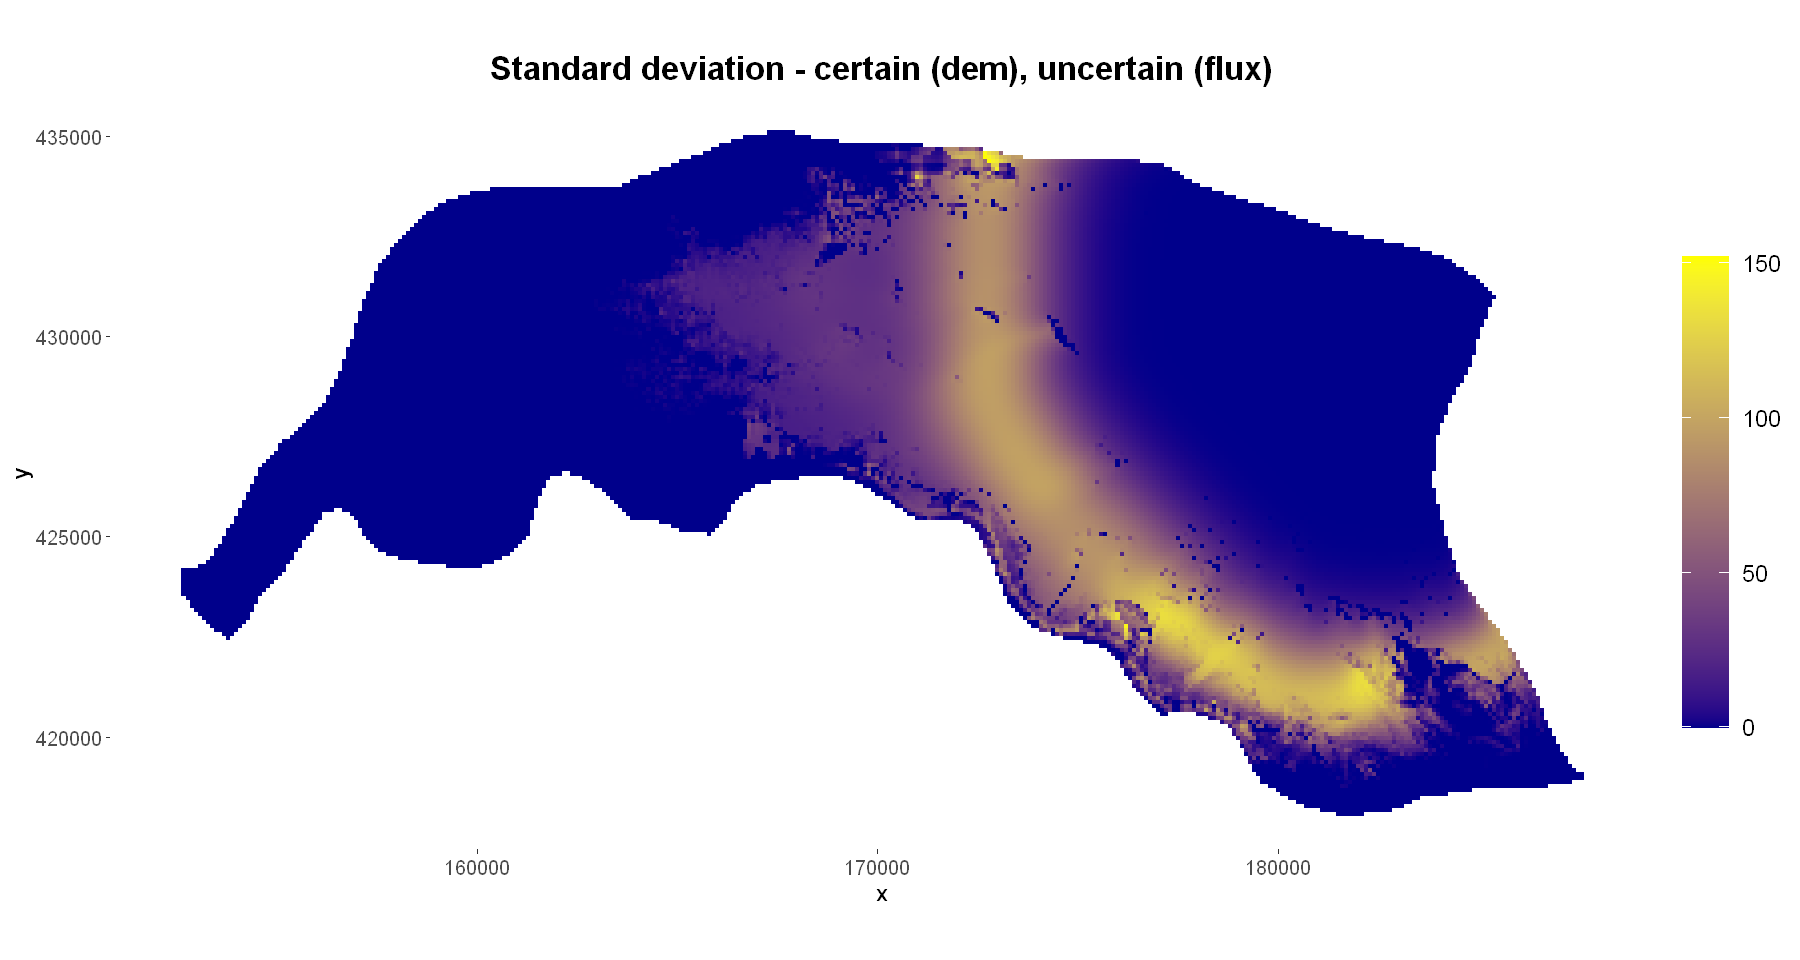

In [267]:
## plot
ggplot() + geom_stars(data=st_sd_cu) + coord_fixed() + template +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Standard deviation - certain (dem), uncertain (flux)")

In [268]:
# Uncertain (dem) - Certain (flux)

## Compute probability of flooding
sd_uc <- apply(ar3D_uc, c(1,2), function(x) sd(x))
sd_uc <- sd_uc + mask[[1]] # get rid of NA area

In [269]:
## Convert to stars raster
st_sd_uc <- st_as_stars(sd_uc)
names(st_sd_uc) <- "sd"
attr(st_sd_uc, "dimensions") <- attr(mask, "dimensions")

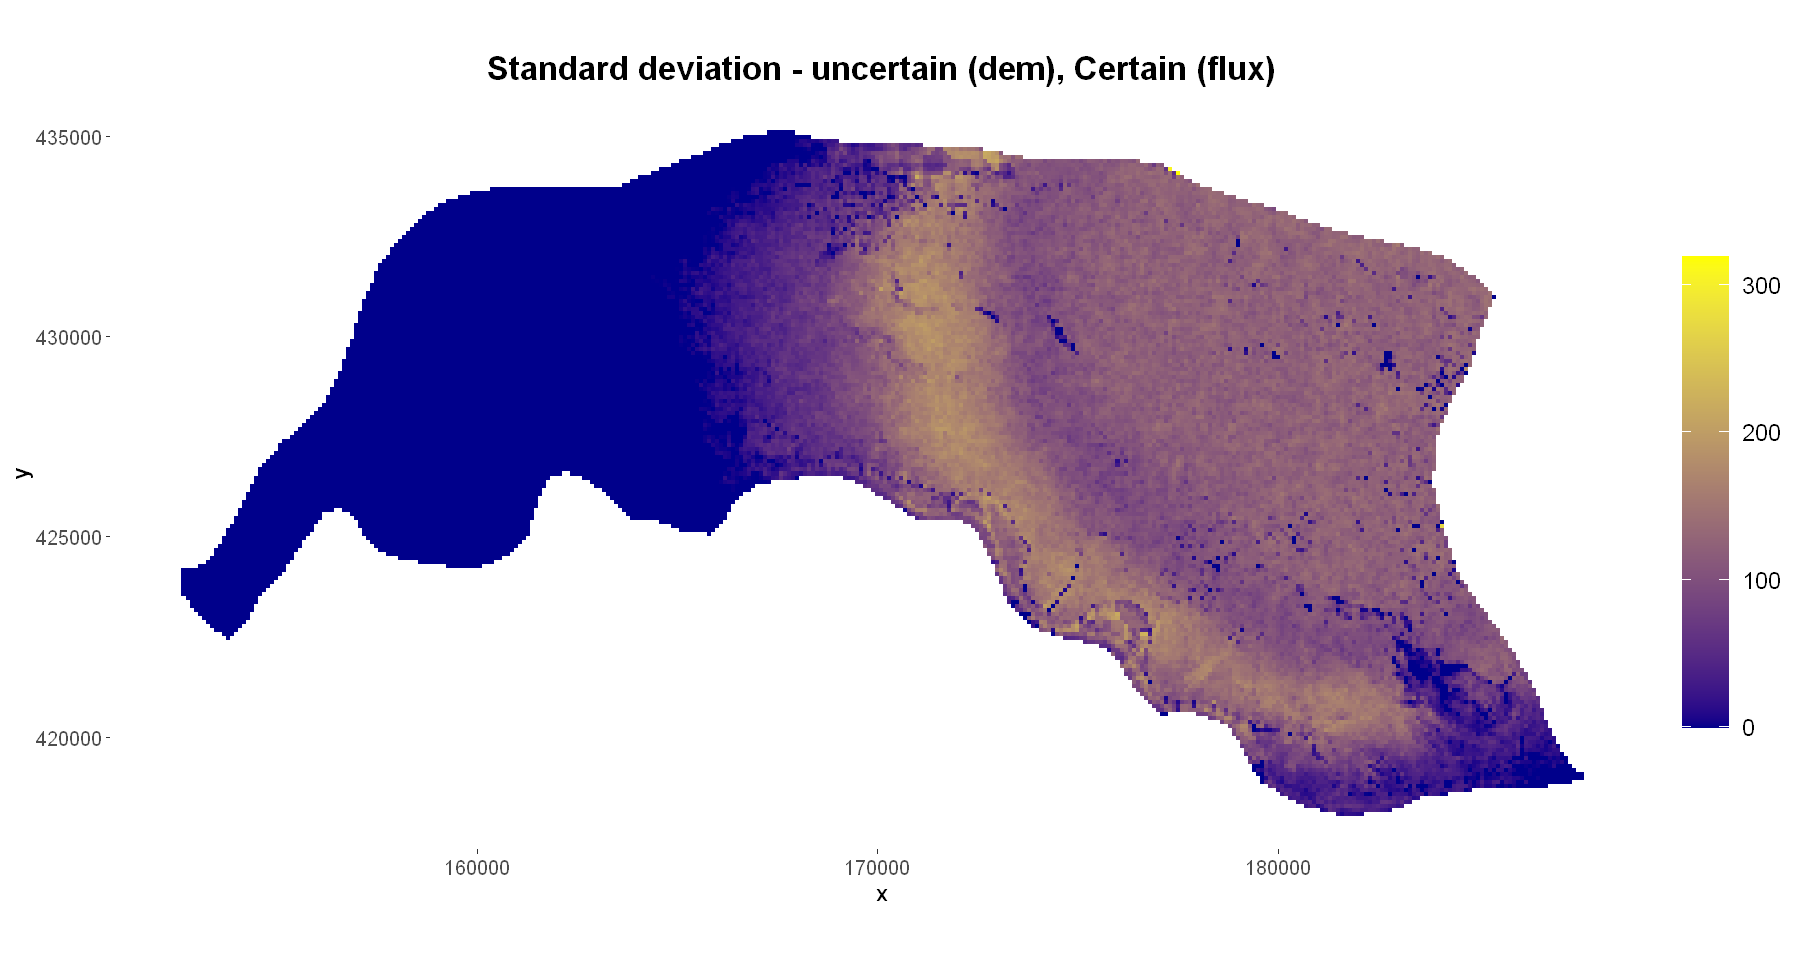

In [311]:
## plot # 28992
ggplot() + template +
  geom_stars(data = st_sd_uc) + 
  coord_fixed() + 
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Standard deviation - uncertain (dem), Certain (flux)")

In [271]:
# Uncertain (dem) - uncertain (flux)

## Compute probability of flooding
sd_uu <- apply(ar3D_uu, c(1,2), function(x) sd(x))
sd_uu <- sd_uu + mask[[1]] # get rid of NA area

In [272]:
## Convert to stars raster
st_sd_uu <- st_as_stars(sd_uu)
names(st_sd_uu) <- "sd"
attr(st_sd_uu, "dimensions") <- attr(mask, "dimensions")

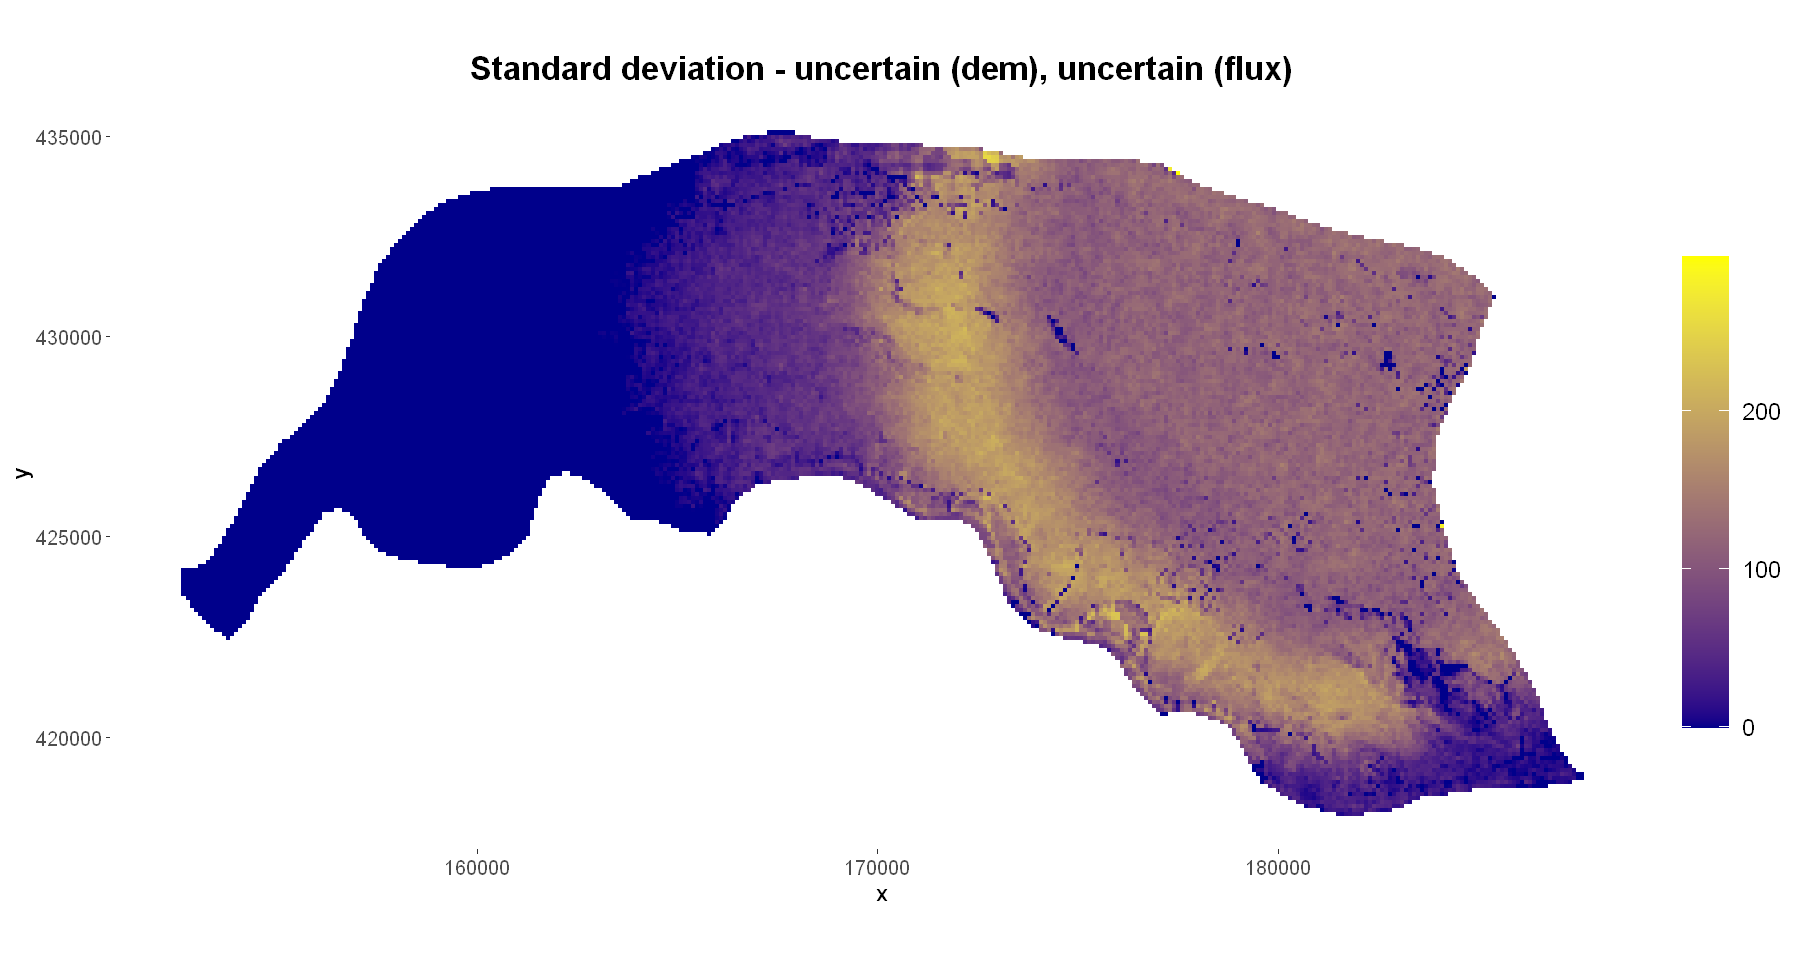

In [273]:
## plot
ggplot() + geom_stars(data=st_sd_uu) + coord_fixed() + template +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Standard deviation - uncertain (dem), uncertain (flux)")

**Relative contribution**

certain (dem) - uncertain (flux)

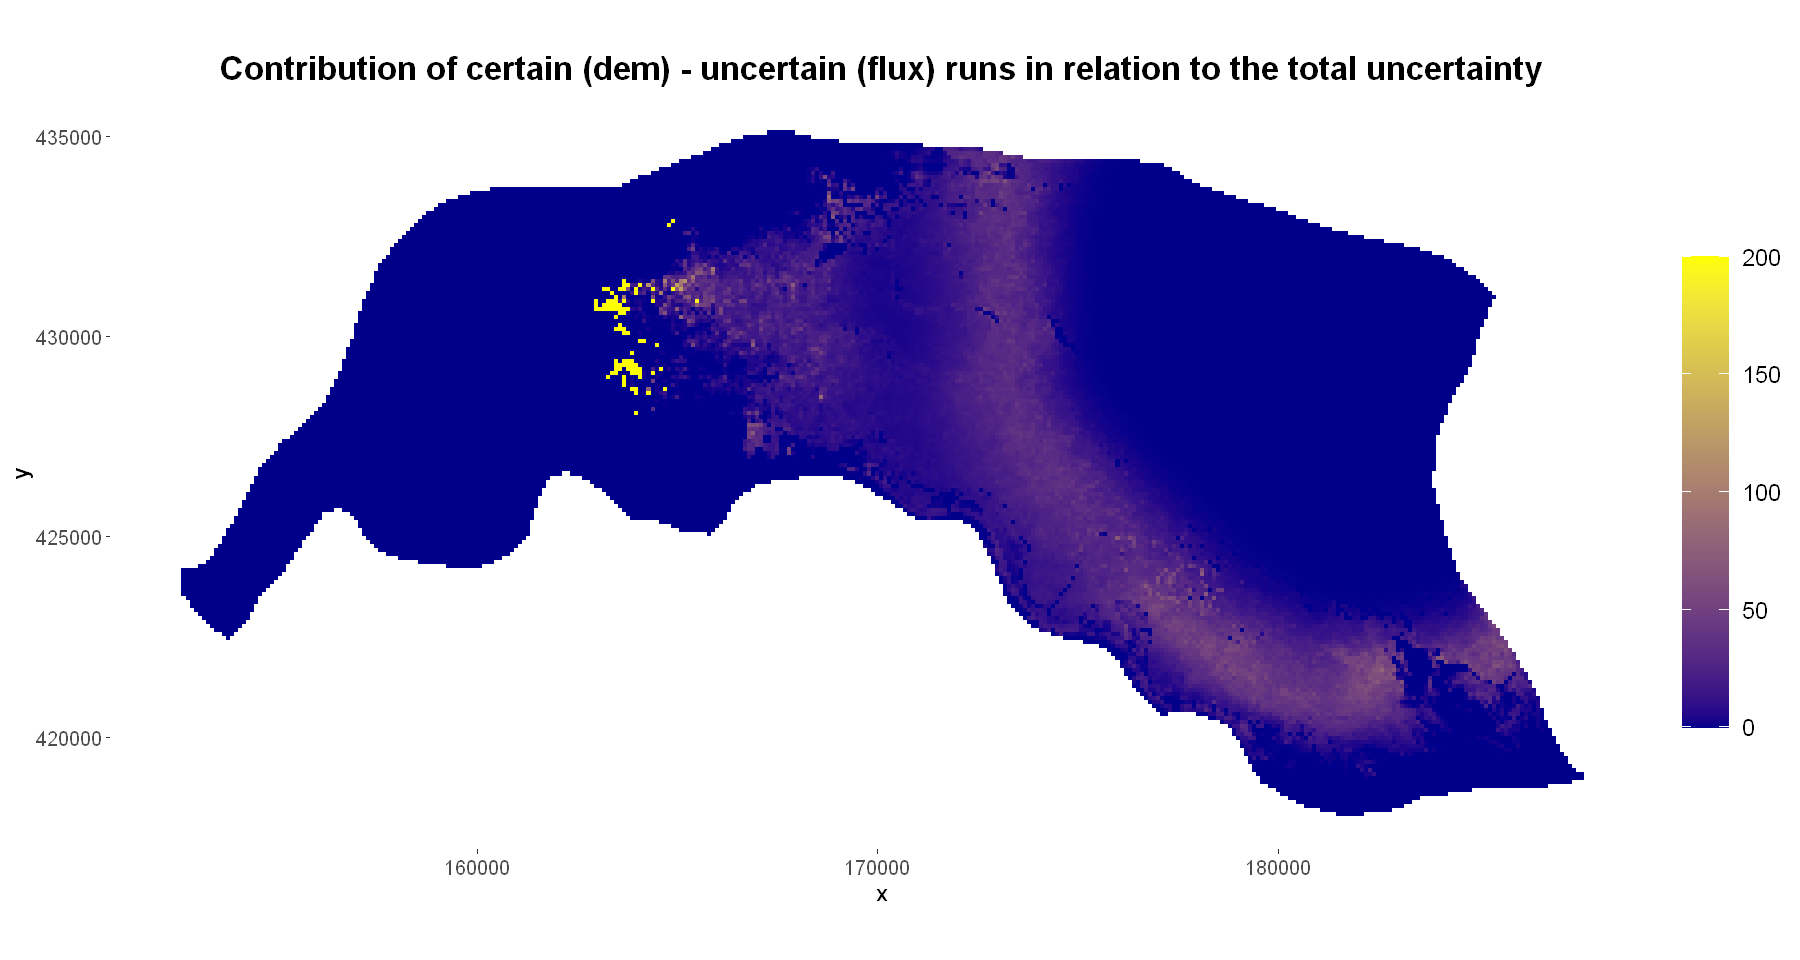

In [274]:
# Relative contribution

contribution_cu = 100 * (st_sd_cu^2 / st_sd_uu^2)
contribution_cu$sd <- pmin(contribution_cu$sd, 200)


contribution_cu[is.na(contribution_cu)] <- 0

## plot
ggplot() + geom_stars(data=contribution_cu + mask) + coord_fixed() + template +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Contribution of certain (dem) - uncertain (flux) runs in relation to the total uncertainty")
#write_stars(contribution_cu, "contribution_cu.tif")

uncertain (dem) - certain (flux)

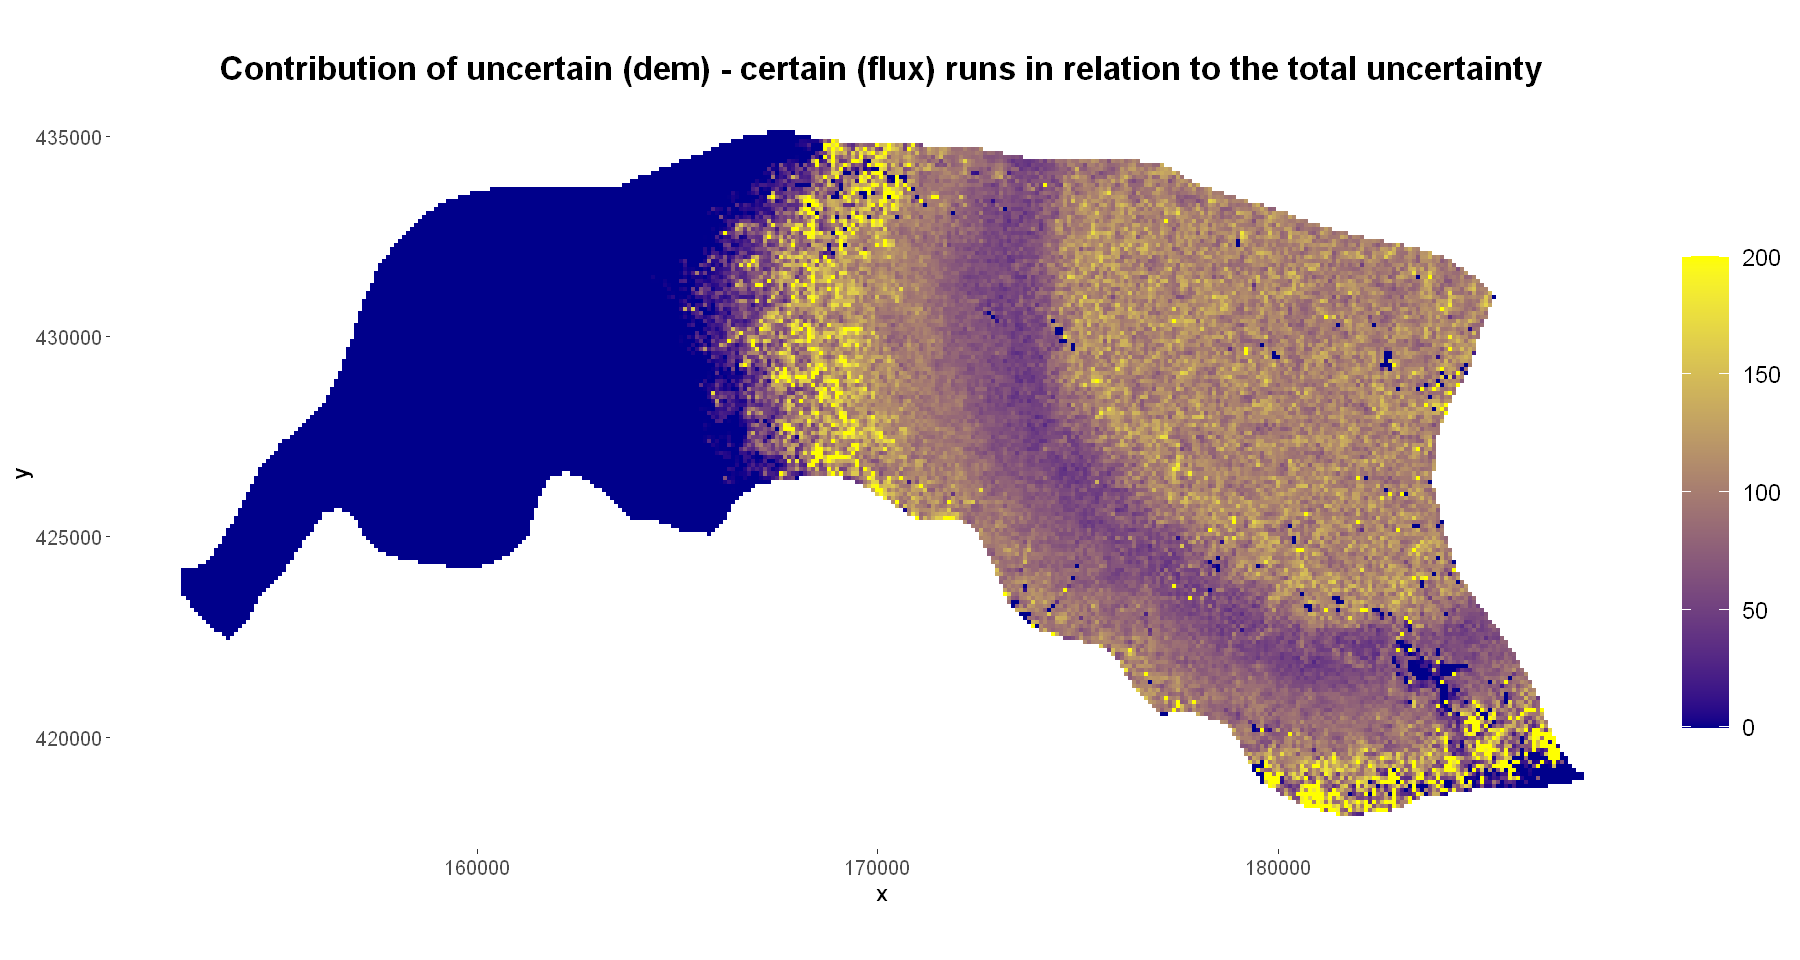

In [275]:
contribution_uc = 100 * st_sd_uc^2 / st_sd_uu^2
contribution_uc$sd <- pmin(contribution_uc$sd, 200)

#mask$mask100.asc <- mask$mask100.asc * 0
contribution_uc[is.na(contribution_uc)] <- 0

## plot
ggplot() + geom_stars(data=contribution_uc + mask) + coord_fixed() + template +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") +
  ggtitle("Contribution of uncertain (dem) - certain (flux) runs in relation to the total uncertainty")
#write_stars(contribution_uc, "contribution_uc.tif")

In [276]:
# Relative contribution
mean(unlist(contribution_cu), na.rm=T); mean(unlist(contribution_uc), na.rm=T)

[1] 4.052498

[1] 34.81911

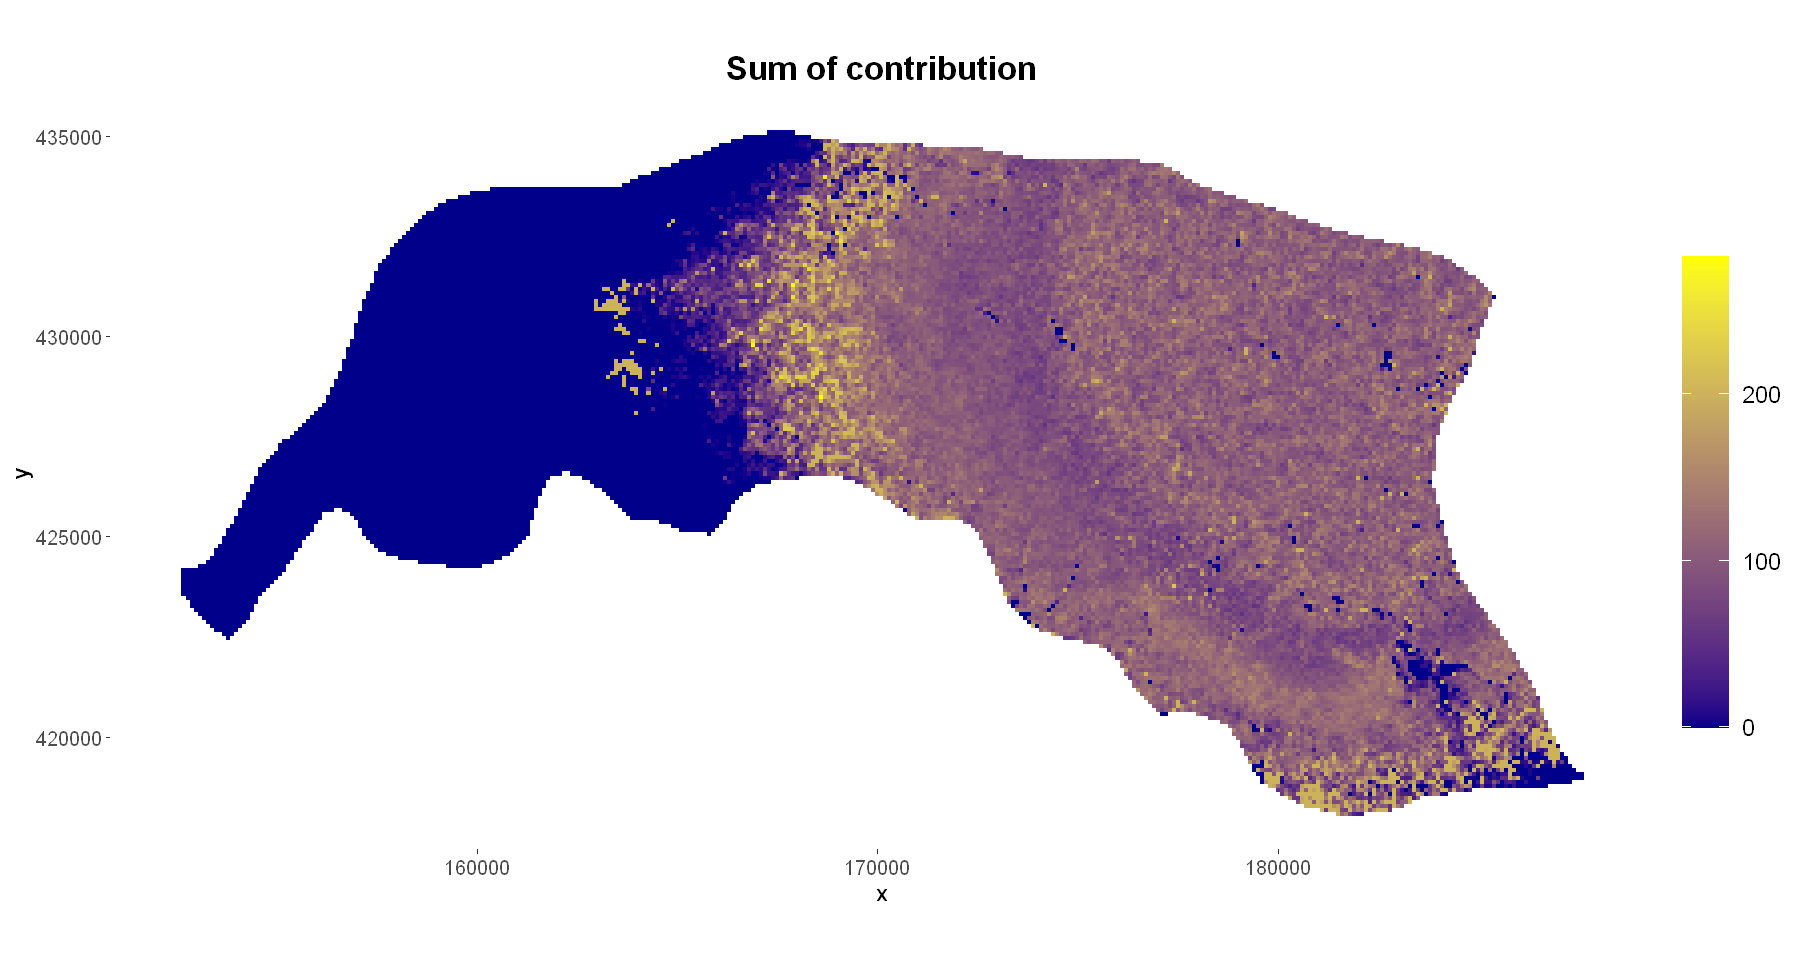

In [277]:
ggplot() + geom_stars(data=contribution_cu + contribution_uc + mask) + coord_fixed() +
  scale_fill_gradient(low="dark blue", high="yellow", name="", na.value="white") + template +
  ggtitle("Sum of contribution")

# 5. References

Hesselink, A.W., Stelling, G.S., Kwadijk, J.C.J., Middelkoop, H., 2003. Inundation of a Dutch river polder, sensitivity analysis of a physically based inundation model using historic data. Water Resources Research 39(9), 1-17. doi:10.1029/2002WR001334

---